# 2 轨迹聚类
<br/><br/>
# 2.0 实习目的与任务

本次实习将对上下车点和轨迹进行聚类分析和可视化，子任务如下

1. 上下车点聚类

2. 上下车点热区分析

3. 轨迹聚类

4. 频繁轨迹分析

5. 轨迹聚类的应用介数


<br/><br/>
*注意，实习2所用processed.csv数据并非实习1提供的，而是另外的一整天数据的处理结果*

*命名为.csv还是.txt并不影响其使用，本质都是文本文件，根据自己习惯即可*

*另外，实习2提供了一套简单的多的武汉市三环主要路网，可用于实习1的地图匹配，速度会快很多*
<br/><br/>

# 2.1 上下车点聚类

In [1]:
import pandas as pd
import numpy as np
# 对某辆出租车轨迹进行分段，提取上下车点
def get_sub_trajectory(df1):
    loads=[]
    no_loads=[]
    on_board=[]
    pick_up=[]
    drop_off=[]
    # 辅助记录
    idx1=-1 #记录每一段轨迹的开始
    idx2=-1 #记录每一段轨迹的结束
    old_status=''
    for index, row in df1.iterrows():
        status=row['空车/重车']
        # 初始化
        if index==0:
            idx1=index
            old_status=status
        # 判断状态是否转变
        # 记录状态改变的行索引
        if status!=old_status:
            sub_df=df1[idx1:idx2+1]
            if old_status=='重车':
                loads.append(sub_df)
                drop_off.append((row['经度'],row['纬度']))#添加下车点列表
            else:
                no_loads.append(sub_df)
                pick_up.append((row['经度'],row['纬度']))#添加上车点列表
            idx1=index
            idx2=index
            old_status=status
        else:
            idx2=index
    sub_df=df1[idx1:idx2+1]
    if old_status=='重车':
        loads.append(sub_df)
    else:
        no_loads.append(sub_df)
    return loads,no_loads,pick_up,drop_off

* 这里我们可以提取其中某一辆车的上下车点进行聚类分析，但由于轨迹点较为稀疏，可能无法呈现很强的空间模式，所以我主要针对某一时间段所有出租车的轨迹进行分析

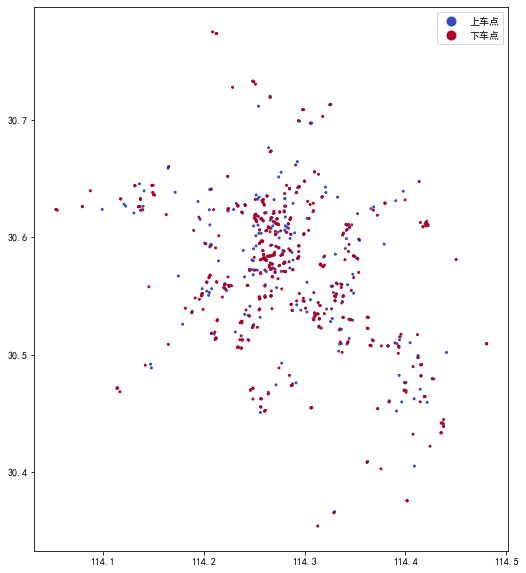

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt

# df=pd.read_csv('data/processed.csv')
# # 针对特定出租车分析
# df1=df[df['出租车ID']==1001]


# 我们还可以针对某一时间段所有出租车的轨迹进行分析
# 这里我们选取实习1中11月5日早上9时——上午11时的全部轨迹数据
df=pd.read_csv('data/processed_1.txt')
df1=df[(df['定位时间']>"2018-11-05 09:00:00")&(df['定位时间']<"2018-11-05 11:00:00")]
x,x,pick_up,drop_off=get_sub_trajectory(df1)



# 构造dataframe便于操作
pick_df=pd.DataFrame(pick_up)
pick_df.columns = ['经度','纬度']
pick_df['类型'] = '上车点'
drop_df=pd.DataFrame(drop_off)
drop_df.columns = ['经度','纬度']
drop_df['类型'] = '下车点'
# index重设
points_df=pick_df.append(drop_df).reset_index(drop=True)
gdf = gpd.GeoDataFrame(
    points_df, geometry=gpd.points_from_xy(points_df['经度'], points_df['纬度']),crs=4326)
plt.rcParams['font.family']=['SimHei']
ax=gdf.plot(column='类型',cmap='coolwarm',legend=True,markersize=4,figsize=(10,10))#根据轨迹点类型用不同颜色可视化

聚类方法有很多，最简单如K均值聚类，目前应用广泛的还有DBSCAN聚类、ST-DBSCAN聚类等基于密度的聚类方法

使用简单的k均值聚类分析上下车热点区域，这里使用sklearn中的相关方法（https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html）

* K-means聚类

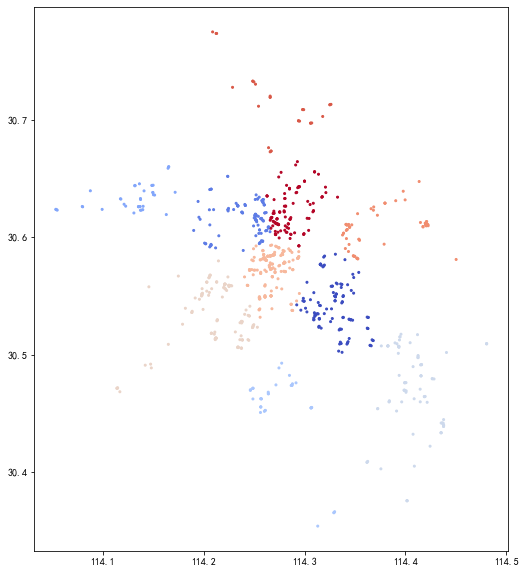

In [3]:
from sklearn.cluster import KMeans

data=np.array(points_df.loc[:, ['经度', '纬度']])
#kmeans,指定10个类
kmeans = KMeans(n_clusters=10).fit(data)
#赋值
points_df['K']=kmeans.labels_
gdf_kmeans = gpd.GeoDataFrame(
    points_df, geometry=gpd.points_from_xy(points_df['经度'], points_df['纬度']),crs=4326)
plt.rcParams['font.family']=['SimHei']
ax=gdf_kmeans.plot(column='K',cmap='coolwarm',markersize=4,figsize=(10,10))

### K-means聚类存在参数选择问题，现使用不同聚类个数进行实验，并进行分析

In [4]:
def cal_silhouette_score(model):
    pred_y = model.predict(data)
    silhouette_score = sm.silhouette_score(data, pred_y, sample_size=len(data), metric='euclidean')
    print(silhouette_score)
    return silhouette_score

0.44955781017604934
0.4460302383621807
0.43848500500619775
0.45815920601934884
0.4283848554178448
0.3670253713989998


<AxesSubplot:title={'center':'聚类个数3'}>

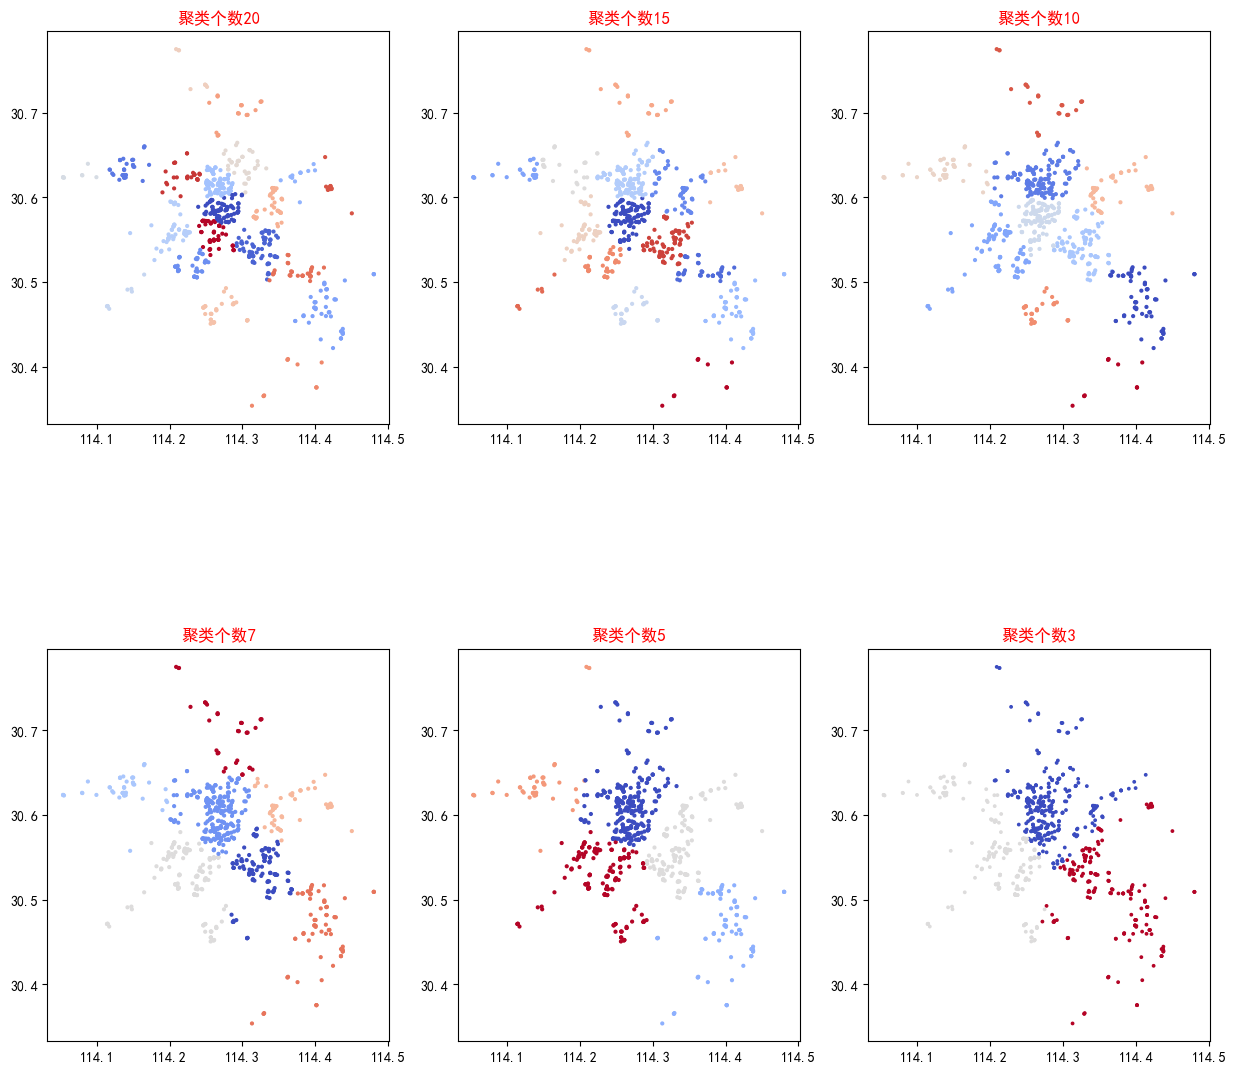

In [5]:
from sklearn.cluster import KMeans

import sklearn.metrics as sm

plt.figure(dpi=100,figsize=(15,15))
plt.rcParams['font.family']=['SimHei']


ax=plt.subplot(2,3,1)

ax.set_title('聚类个数20',fontsize=12,color='r')
data=np.array(points_df.loc[:, ['经度', '纬度']])
#kmeans,指定10个类
kmeans = KMeans(n_clusters=20).fit(data)

#评价聚类
cal_silhouette_score(kmeans)

#赋值
points_df['K']=kmeans.labels_
gdf_kmeans = gpd.GeoDataFrame(
    points_df, geometry=gpd.points_from_xy(points_df['经度'], points_df['纬度']),crs=4326)

gdf_kmeans.plot(ax=ax,column='K',cmap='coolwarm',markersize=4)

ax=plt.subplot(2,3,2)

ax.set_title('聚类个数15',fontsize=12,color='r')
data=np.array(points_df.loc[:, ['经度', '纬度']])

kmeans = KMeans(n_clusters=15).fit(data)

#评价聚类
cal_silhouette_score(kmeans)

#赋值
points_df['K']=kmeans.labels_
gdf_kmeans = gpd.GeoDataFrame(
    points_df, geometry=gpd.points_from_xy(points_df['经度'], points_df['纬度']),crs=4326)

gdf_kmeans.plot(ax=ax,column='K',cmap='coolwarm',markersize=4)


ax=plt.subplot(2,3,3)

ax.set_title('聚类个数10',fontsize=12,color='r')
data=np.array(points_df.loc[:, ['经度', '纬度']])

kmeans = KMeans(n_clusters=10).fit(data)
#评价聚类
cal_silhouette_score(kmeans)
#赋值
points_df['K']=kmeans.labels_
gdf_kmeans = gpd.GeoDataFrame(
    points_df, geometry=gpd.points_from_xy(points_df['经度'], points_df['纬度']),crs=4326)

gdf_kmeans.plot(ax=ax,column='K',cmap='coolwarm',markersize=4)

ax=plt.subplot(2,3,4)

ax.set_title('聚类个数7',fontsize=12,color='r')
data=np.array(points_df.loc[:, ['经度', '纬度']])

kmeans = KMeans(n_clusters=7).fit(data)
#评价聚类
cal_silhouette_score(kmeans)

#赋值
points_df['K']=kmeans.labels_
gdf_kmeans = gpd.GeoDataFrame(
    points_df, geometry=gpd.points_from_xy(points_df['经度'], points_df['纬度']),crs=4326)

gdf_kmeans.plot(ax=ax,column='K',cmap='coolwarm',markersize=4)

ax=plt.subplot(2,3,5)

ax.set_title('聚类个数5',fontsize=12,color='r')
data=np.array(points_df.loc[:, ['经度', '纬度']])

kmeans = KMeans(n_clusters=5).fit(data)

#评价聚类
cal_silhouette_score(kmeans)

#赋值
points_df['K']=kmeans.labels_
gdf_kmeans = gpd.GeoDataFrame(
    points_df, geometry=gpd.points_from_xy(points_df['经度'], points_df['纬度']),crs=4326)

gdf_kmeans.plot(ax=ax,column='K',cmap='coolwarm',markersize=4)

ax=plt.subplot(2,3,6)

ax.set_title('聚类个数3',fontsize=12,color='r')
data=np.array(points_df.loc[:, ['经度', '纬度']])

kmeans = KMeans(n_clusters=3).fit(data)

#评价聚类
cal_silhouette_score(kmeans)

#赋值
points_df['K']=kmeans.labels_
gdf_kmeans = gpd.GeoDataFrame(
    points_df, geometry=gpd.points_from_xy(points_df['经度'], points_df['纬度']),crs=4326)

gdf_kmeans.plot(ax=ax,column='K',cmap='coolwarm',markersize=3)


* 可以注意到在聚类个数为3时，轨迹点分别聚集在武昌、汉口、汉阳，这一结果符合我们的常规认知，因为这三地为长江、汉江所分隔
* 聚类数为5时，可以看到街道口附近与光谷附近形成两个聚类，这个在生活中也有所感触（武大学生常在街道口附近活动，而华科学生更倾向在光谷一带活动）

### 但实际分析中究竟应该选择多大的聚类数呢？（客观指标评价聚类水平）
除了结合实际主观判断，还存在相应的客观指标评价聚类水平，从而确定最优聚类数目

In [6]:
#用轮廓系数评判聚类质量
import sklearn.metrics as sm


# 好的聚类：内密外疏，同一个聚类内部的样本要足够密集，不同聚类之间样本要足够疏远。

# 轮廓系数计算规则：针对样本空间中的一个特定样本，计算它与所在聚类其它样本的平均距离a，

# 以及该样本与距离最近的另一个聚类中所有样本的平均距离b，该样本的轮廓系数为(b-a)/max(a, b)，

# 将整个样本空间中所有样本的轮廓系数取算数平均值，作为聚类划分的性能指标s。
# 轮廓系数的区间为：[-1, 1]。 -1代表分类效果差，1代表分类效果好。0代表聚类重叠，没有很好的划分聚类。


def cal_silhouette_score(model):
    pred_y = model.predict(data)
    silhouette_score = sm.silhouette_score(data, pred_y, sample_size=len(data), metric='euclidean')
    print(silhouette_score)
    return silhouette_score


* 在kmeans聚类数分别为20,15,10,7,5,3时，15对应的silhouette_score最高，为0.4539871841856424，故聚类数确定在15附近效果较好

### 再尝试DBSCAN聚类，该方法核心参数为距离阈值，此外还有样本数量阈值、距离计算方法等参数可以设置

该算法相比于K均值具有显著的优势，目前应用十分广泛，同学们可以自行学习该算法，并试着调整参数、比较结果

聚类数： 46


D:\Anaconda_py38\anaconda\lib\site-packages\geopandas\plotting.py:641: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


<AxesSubplot:>

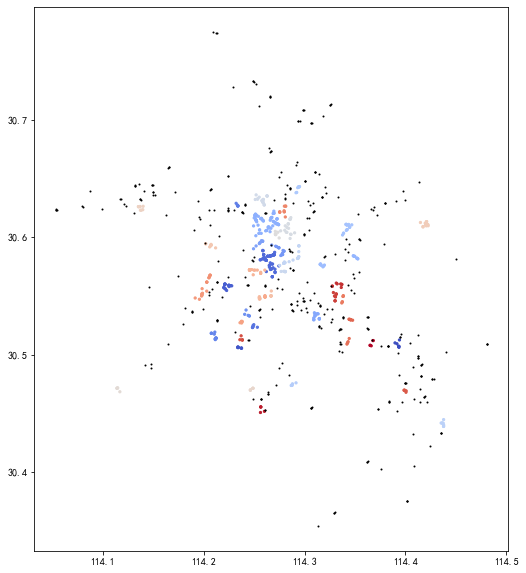

In [7]:
from sklearn.cluster import DBSCAN

#eps参数是什么意思？
#eps是样本与样本间被认为是相邻的最大距离(The maximum distance between two samples for one to be considered as in the neighborhood of the other.)

#eps参数为距离阈值，min_samples是确定一个点是core points所需的neighborhood中点数阈值，metric是距离计算方式
#sklearn提供了多种距离度量方式，
#这其中包括[‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘correlation’, ‘dice’, ‘hamming’, ‘jaccard’, ‘kulsinski’, ‘mahalanobis’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’] 

db=DBSCAN(eps=0.005).fit(data)
#赋值
points_df['DB']=db.labels_
print('聚类数：',len(set(db.labels_)))
#核心
core=points_df[points_df['DB']>-1]

#边界(Noisy samples are given the label -1.)
border=points_df[points_df['DB']==-1]

# 分别可视化
plt.rcParams['font.family']=['SimHei']

gdf_dbscan = gpd.GeoDataFrame(
    core, geometry=gpd.points_from_xy(core['经度'], core['纬度']),crs=4326)
ax=gdf_dbscan.plot(column='DB',cmap='coolwarm',markersize=5,figsize=(10,10))

gdf_dbscan0 = gpd.GeoDataFrame(
    border, geometry=gpd.points_from_xy(border['经度'], border['纬度']),crs=4326)
gdf_dbscan0.plot(ax=ax,column='DB',color='black',markersize=1,figsize=(10,10))

聚类数： 23


D:\Anaconda_py38\anaconda\lib\site-packages\geopandas\plotting.py:641: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


<AxesSubplot:>

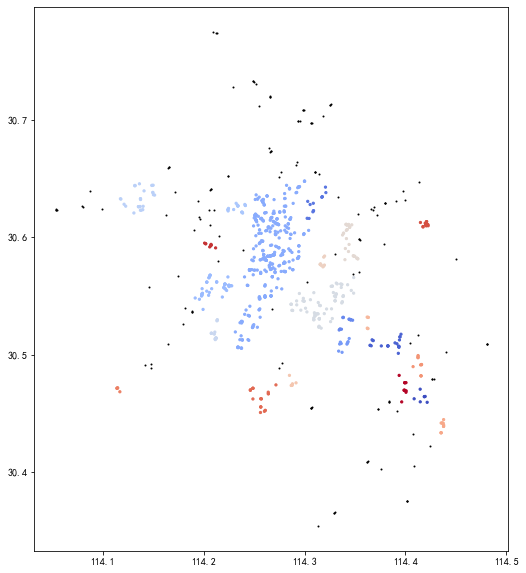

In [8]:
from sklearn.cluster import DBSCAN

#eps参数是什么意思？
#eps是样本与样本间被认为是相邻的最大距离(The maximum distance between two samples for one to be considered as in the neighborhood of the other.)
db=DBSCAN(eps=0.01).fit(data)
#赋值
points_df['DB']=db.labels_
print('聚类数：',len(set(db.labels_)))
#核心
core=points_df[points_df['DB']>-1]

#边界(Noisy samples are given the label -1.)
border=points_df[points_df['DB']==-1]

# 分别可视化
plt.rcParams['font.family']=['SimHei']

gdf_dbscan = gpd.GeoDataFrame(
    core, geometry=gpd.points_from_xy(core['经度'], core['纬度']),crs=4326)
ax=gdf_dbscan.plot(column='DB',cmap='coolwarm',markersize=5,figsize=(10,10))

gdf_dbscan0 = gpd.GeoDataFrame(
    border, geometry=gpd.points_from_xy(border['经度'], border['纬度']),crs=4326)
gdf_dbscan0.plot(ax=ax,column='DB',color='black',markersize=1,figsize=(10,10))

聚类数： 32


D:\Anaconda_py38\anaconda\lib\site-packages\geopandas\plotting.py:641: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


<AxesSubplot:>

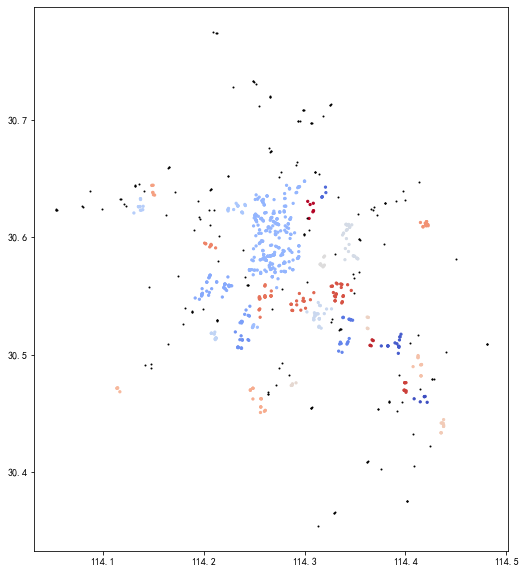

In [9]:
from sklearn.cluster import DBSCAN

#eps参数是什么意思？
#eps是样本与样本间被认为是相邻的最大距离(The maximum distance between two samples for one to be considered as in the neighborhood of the other.)
db=DBSCAN(eps=0.01,min_samples=5, metric='l1').fit(data)
#赋值
points_df['DB']=db.labels_
print('聚类数：',len(set(db.labels_)))
#核心
core=points_df[points_df['DB']>-1]

#边界(Noisy samples are given the label -1.)
border=points_df[points_df['DB']==-1]

# 分别可视化
plt.rcParams['font.family']=['SimHei']

gdf_dbscan = gpd.GeoDataFrame(
    core, geometry=gpd.points_from_xy(core['经度'], core['纬度']),crs=4326)
ax=gdf_dbscan.plot(column='DB',cmap='coolwarm',markersize=5,figsize=(10,10))

gdf_dbscan0 = gpd.GeoDataFrame(
    border, geometry=gpd.points_from_xy(border['经度'], border['纬度']),crs=4326)
gdf_dbscan0.plot(ax=ax,column='DB',color='black',markersize=1,figsize=(10,10))

### 对比分析K-means、DBSCAN距离结果

D:\Anaconda_py38\anaconda\lib\site-packages\geopandas\plotting.py:641: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


<AxesSubplot:>

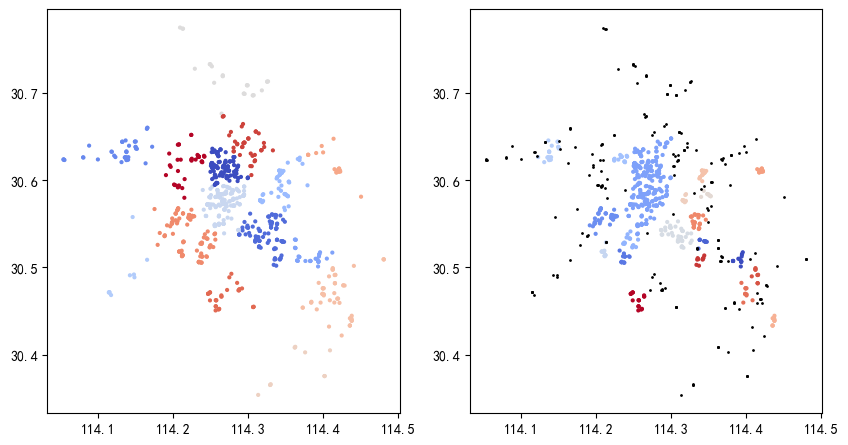

In [10]:
#K-means参数调节

data=np.array(points_df.loc[:, ['经度', '纬度']])
#kmeans
kmeans = KMeans(n_clusters=15).fit(data)
#赋值
points_df['K']=kmeans.labels_

#DBSCAN参数调节
db=DBSCAN(eps=0.01,min_samples=10, metric='euclidean').fit(data)
#eps参数为距离阈值，min_samples是确定一个点是core points所需的neighborhood中点数阈值，metric是距离计算方式
#sklearn提供了多种距离度量方式，这其中包括[‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘correlation’, ‘dice’, ‘hamming’, ‘jaccard’, ‘kulsinski’, ‘mahalanobis’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’] 

#赋值
points_df['DB']=db.labels_
#核心
core=points_df[points_df['DB']>-1]

#边界(Noisy samples are given the label -1.)
border=points_df[points_df['DB']==-1]




plt.figure(figsize=(10,10), dpi=100)
plt.rcParams['font.family']=['SimHei']
ax = plt.subplot(1,2,1)
gdf_kmeans.plot(ax=ax,column='K',cmap='coolwarm',markersize=4,figsize=(10,10))


ax = plt.subplot(1,2,2)
gdf_dbscan = gpd.GeoDataFrame(
    core, geometry=gpd.points_from_xy(core['经度'], core['纬度']),crs=4326)
gdf_dbscan.plot(ax=ax,column='DB',cmap='coolwarm',markersize=4,figsize=(10,10))

gdf_dbscan0 = gpd.GeoDataFrame(
    border, geometry=gpd.points_from_xy(border['经度'], border['纬度']),crs=4326)
gdf_dbscan0.plot(ax=ax,column='DB',color='black',markersize=1,figsize=(10,10))

### Mean-Shift聚类

C:\Users\57358\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass bandwidth=0.001 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


0.5666571457501844


C:\Users\57358\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass bandwidth=0.005 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


0.6247175360348267


C:\Users\57358\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass bandwidth=0.001 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


0.5666571457501844


C:\Users\57358\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass bandwidth=0.02 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


0.4650139089081917


C:\Users\57358\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass bandwidth=0.03 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


0.3756882714025546


C:\Users\57358\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass bandwidth=0.05 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


0.3820412620438774


0.3820412620438774

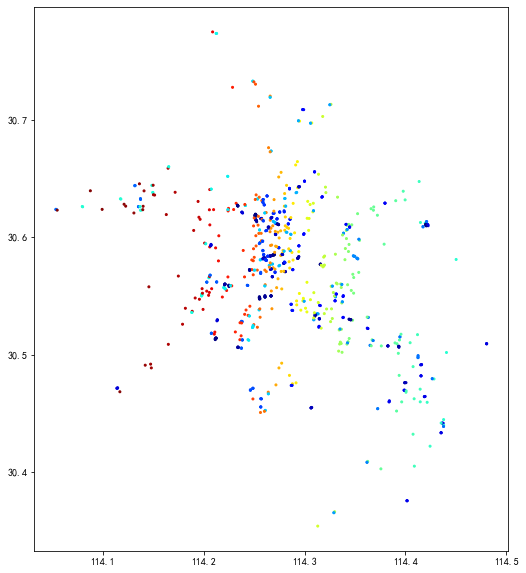

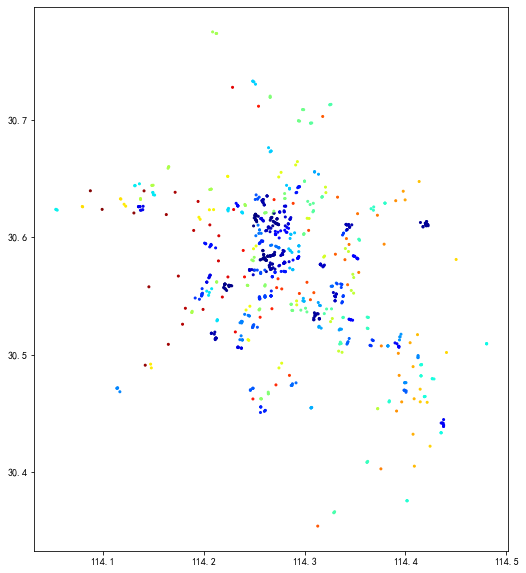

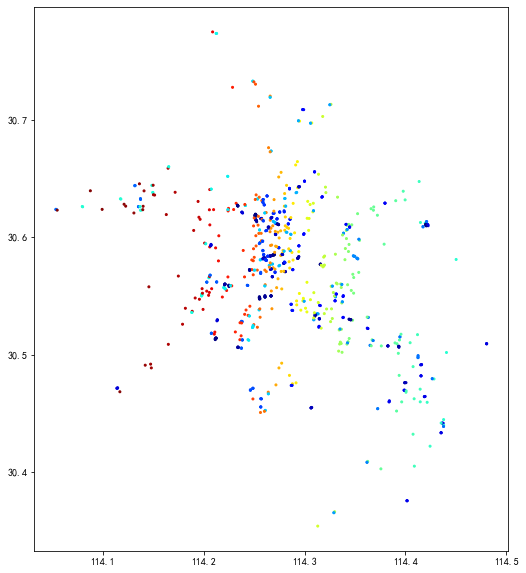

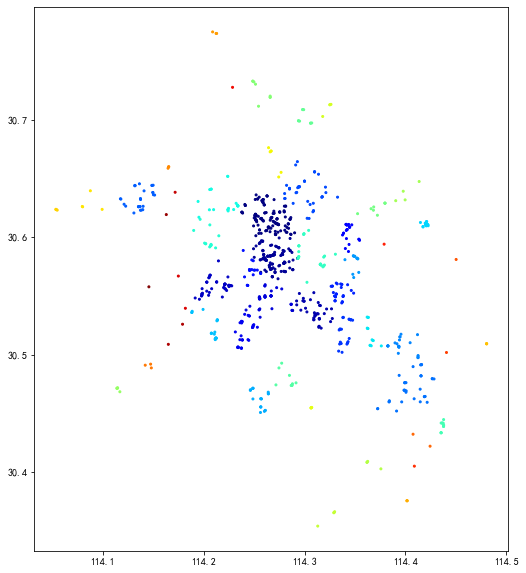

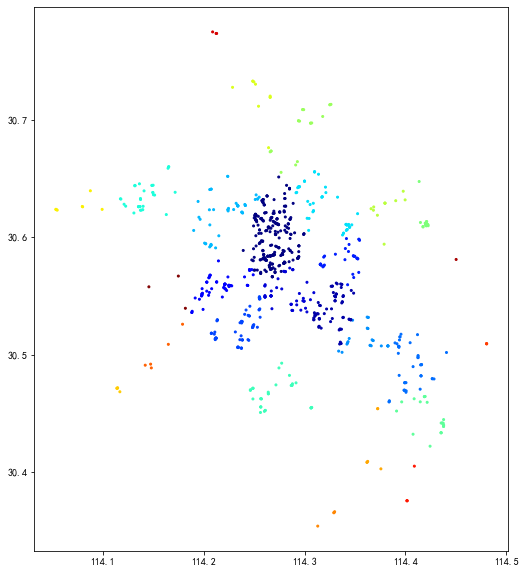

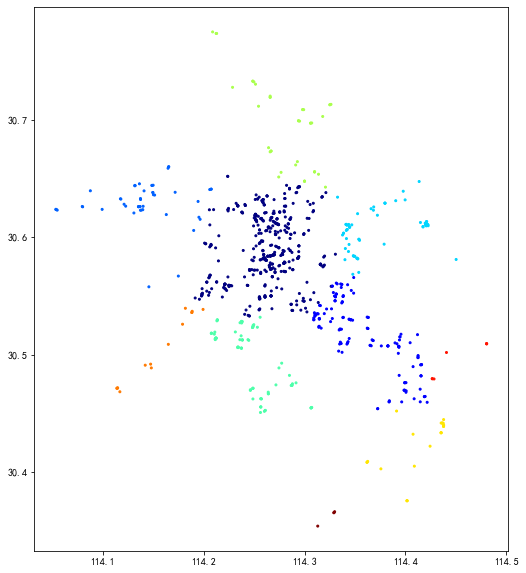

In [11]:
from sklearn.cluster import MeanShift
data=np.array(points_df.loc[:, ['经度', '纬度']])

ms =MeanShift(0.001).fit(data)
label_num=len(set(ms.labels_))
points_df['M']=ms.labels_

gdf_kmeans = gpd.GeoDataFrame(
    points_df, geometry=gpd.points_from_xy(points_df['经度'], points_df['纬度']),crs=4326)
ax1=plt.rcParams['font.family']=['SimHei']
ax1=gdf_kmeans.plot(column='M',cmap='jet',markersize=4,figsize=(10,10))
cal_silhouette_score(ms)

ms =MeanShift(0.005).fit(data)
label_num=len(set(ms.labels_))
points_df['M']=ms.labels_
gdf_ms = gpd.GeoDataFrame(
    points_df, geometry=gpd.points_from_xy(points_df['经度'], points_df['纬度']),crs=4326)
plt.rcParams['font.family']=['SimHei']
ax2=gdf_ms.plot(column='M',cmap='jet',markersize=4,figsize=(10,10))
cal_silhouette_score(ms)


ms =MeanShift(0.001).fit(data)
label_num=len(set(ms.labels_))
points_df['M']=ms.labels_
gdf_ms = gpd.GeoDataFrame(
    points_df, geometry=gpd.points_from_xy(points_df['经度'], points_df['纬度']),crs=4326)
plt.rcParams['font.family']=['SimHei']
ax2=gdf_ms.plot(column='M',cmap='jet',markersize=4,figsize=(10,10))
cal_silhouette_score(ms)


ms =MeanShift(0.02).fit(data)
label_num=len(set(ms.labels_))
points_df['M']=ms.labels_
gdf_ms = gpd.GeoDataFrame(
    points_df, geometry=gpd.points_from_xy(points_df['经度'], points_df['纬度']),crs=4326)
plt.rcParams['font.family']=['SimHei']
ax2=gdf_ms.plot(column='M',cmap='jet',markersize=4,figsize=(10,10))
cal_silhouette_score(ms)


ms =MeanShift(0.03).fit(data)
label_num=len(set(ms.labels_))
points_df['M']=ms.labels_
gdf_ms = gpd.GeoDataFrame(
    points_df, geometry=gpd.points_from_xy(points_df['经度'], points_df['纬度']),crs=4326)
plt.rcParams['font.family']=['SimHei']
ax2=gdf_ms.plot(column='M',cmap='jet',markersize=4,figsize=(10,10))
cal_silhouette_score(ms)


ms =MeanShift(0.05).fit(data)
label_num=len(set(ms.labels_))
points_df['M']=ms.labels_
gdf_ms = gpd.GeoDataFrame(
    points_df, geometry=gpd.points_from_xy(points_df['经度'], points_df['纬度']),crs=4326)
plt.rcParams['font.family']=['SimHei']
ax3=gdf_ms.plot(column='M',cmap='jet',markersize=4,figsize=(10,10))
cal_silhouette_score(ms)

* 当参数为0.05时聚类效果较好

# 2.2 上下车点热区分析

下面我们使用所有的出租车轨迹，进行上下车点的热区分析。

由于数据较大，这里需要等待一段时间的运行

同学们可以换成实习1的数据，跑起来快得多（已换）

In [12]:
import pandas as pd

df=pd.read_csv('data/processed_1.txt')
# 对所有的出租车
pick=pd.DataFrame()
drop=pd.DataFrame()
for tid in set(df['出租车ID']):
    df1=df[df['出租车ID']==tid].reset_index(drop=True)
    x,x,pick_up,drop_off=get_sub_trajectory(df1)
    if len(pick_up)>0:
        pick_df=pd.DataFrame(pick_up)
        pick_df.columns = ['经度','纬度']
        pick_df['类型'] = '上车点'
        pick=pick.append(pick_df)
    if len(drop_off)>0:
        drop_df=pd.DataFrame(drop_off)
        drop_df.columns = ['经度','纬度']
        drop_df['类型'] = '下车点'
        drop=drop.append(drop_df)
pick=pick.reset_index(drop=True)
drop=drop.reset_index(drop=True)

### 叠加核密度和DBSCAN聚类结果进行分析 

D:\Anaconda_py38\anaconda\lib\site-packages\geopandas\plotting.py:641: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
D:\Anaconda_py38\anaconda\lib\site-packages\geopandas\plotting.py:641: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


<AxesSubplot:>

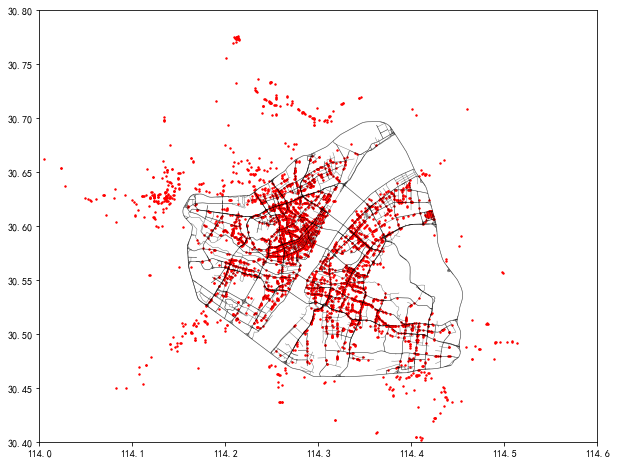

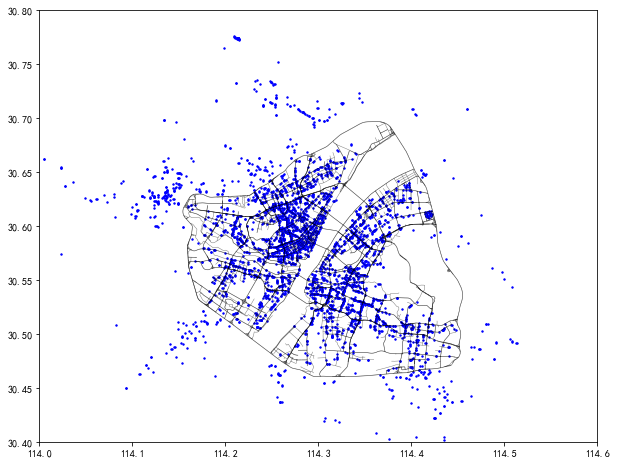

In [13]:
import geoplot as gplt
gdf_pick = gpd.GeoDataFrame(
    pick, geometry=gpd.points_from_xy(pick['经度'], pick['纬度']),crs=4326)
gdf_drop = gpd.GeoDataFrame(
    drop, geometry=gpd.points_from_xy(drop['经度'], drop['纬度']),crs=4326)
plt.rcParams['font.family']=['SimHei']

ax1=gdf_pick.plot(column='类型',color='red',legend=True,markersize=2,figsize=(10,10))
ax1.set_ylim([30.4,30.8])
ax1.set_xlim([114.0,114.6])
ax2=gdf_drop.plot(column='类型',color='blue',legend=True,markersize=2,figsize=(10,10))
ax2.set_ylim([30.4,30.8])
ax2.set_xlim([114.0,114.6])

wuhan_road = gpd.GeoDataFrame.from_file('data/road/WHroad.shp')  # 叠加武汉市路网
wuhan_road.plot(ax=ax1,linewidth = 0.5, alpha = 0.5, color = 'black')
wuhan_road.plot(ax=ax2,linewidth = 0.5, alpha = 0.5, color = 'black')




D:\Anaconda_py38\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\Anaconda_py38\anaconda\lib\site-packages\seaborn\distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
D:\Anaconda_py38\anaconda\lib\site-packages\geopandas\plotting.py:641: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
D:\Anaconda_py38\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or mi

<AxesSubplot:>

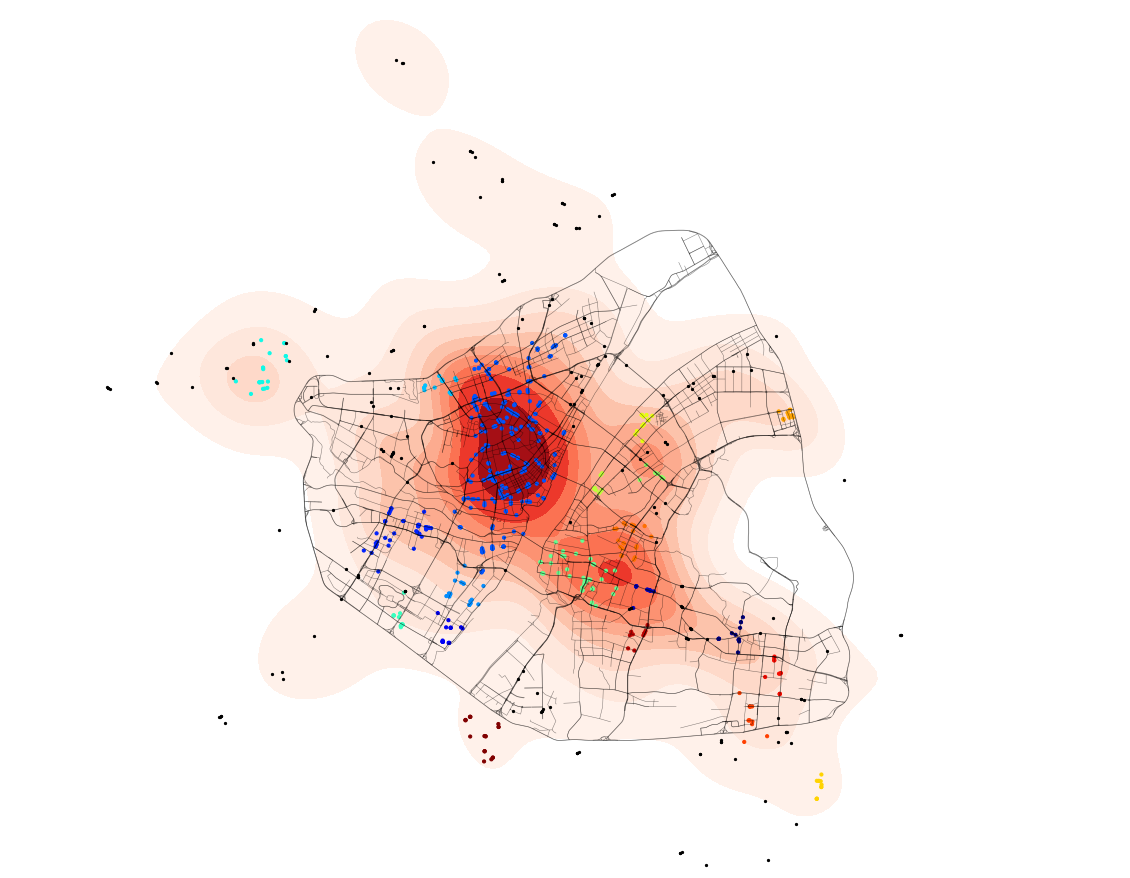

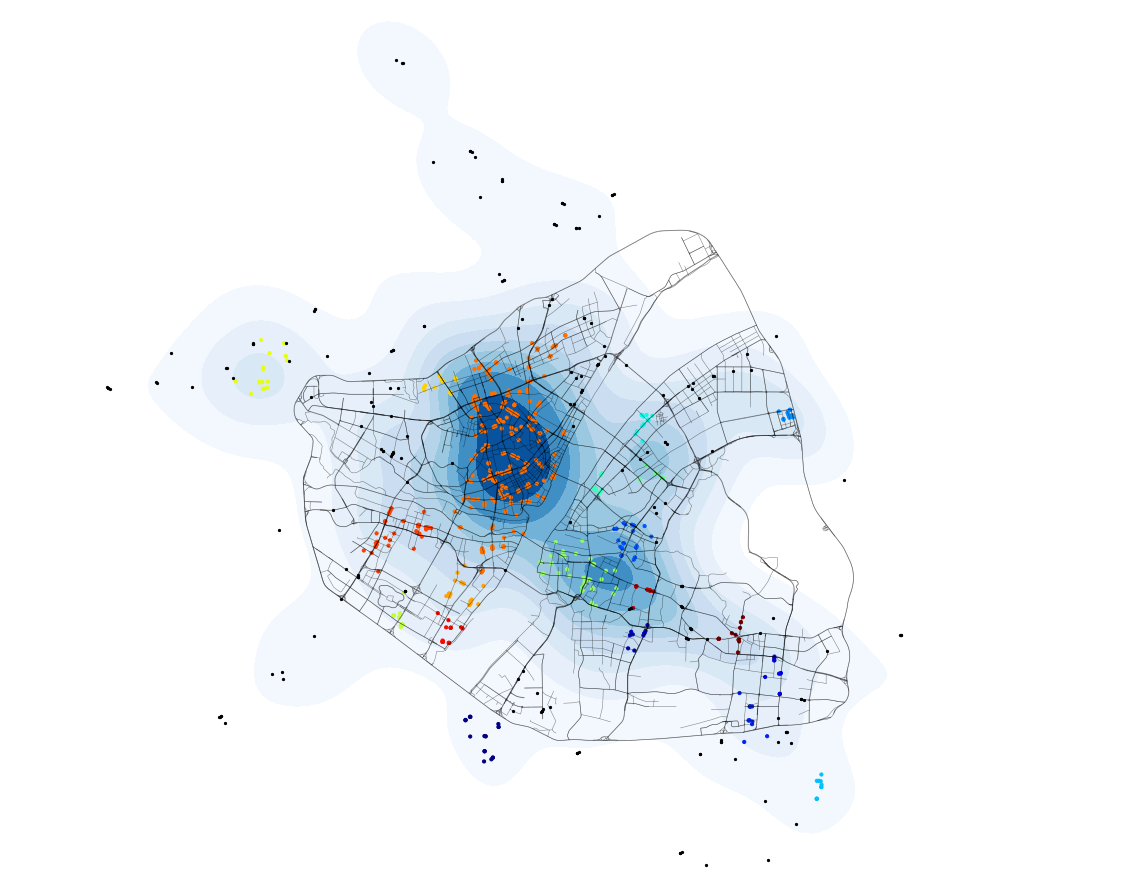

In [14]:




ax1=gplt.kdeplot(df=gdf_pick,cmap='Reds',shade=True,figsize=(20,20))
ax1.set_ylim([30.4,30.8])
ax1.set_xlim([114.0,114.6])
gdf_dbscan.plot(ax=ax1,column='DB',cmap='jet',markersize=10,figsize=(20,20))
gdf_dbscan0.plot(ax=ax1,column='DB',color='black',markersize=5,figsize=(20,20))

ax2=gplt.kdeplot(df=gdf_drop,cmap='Blues',shade=True,figsize=(20,20))
ax2.set_ylim([30.4,30.8])
ax2.set_xlim([114.0,114.6])
gdf_dbscan.plot(ax=ax2,column='DB',cmap='jet_r',markersize=10,figsize=(20,20))
gdf_dbscan0.plot(ax=ax2,column='DB',color='black',markersize=5,figsize=(20,20))

# 路网参考
wuhan_road.plot(ax=ax1,linewidth = 0.5, alpha = 0.5, color = 'black')
wuhan_road.plot(ax=ax2,linewidth = 0.5, alpha = 0.5, color = 'black')




* 可以发现上下车点的一大高热度区域在聚类中自成一派，主要分布在汉口江滩，长江与汉江交汇处一带，可以是因为该区域连通武昌和汉阳，是市内通勤的交通枢纽，此外这也是武汉最繁华的区域之一（人群活动频繁）
*另一大高热度区域是黄鹤楼一带，上下车点也聚成一类，可能是该区域内游客往来频繁

* geoplot的kdeplot还有众多调整参数，可以尝试进行参数调整，得到更好的效果
geoplot提供了很多high level api, 其中kdeplot就是来自seaborn.kdeplot
其参数包括(x=None, *, y=None, shade=None, vertical=False, kernel=None, bw=None, gridsize=200, cut=3, clip=None, legend=True, cumulative=False, shade_lowest=None, cbar=False, cbar_ax=None, cbar_kws=None, ax=None, weights=None, hue=None, palette=None, hue_order=None, hue_norm=None, multiple='layer', common_norm=True, common_grid=False, levels=10, thresh=0.05, bw_method='scott', bw_adjust=1, log_scale=None, color=None, fill=None, data=None, data2=None, **kwargs)

kernel 决定核函数  
bw bandwidth 带宽，决定平滑程度  
bw_method 决定带宽计算方法  

D:\Anaconda_py38\anaconda\lib\site-packages\geoplot\geoplot.py:626: UserWarning: Cannot set "figsize" when passing an "ax" to the plot. To remove this warning omit the "figsize" parameter.
  warnings.warn(
D:\Anaconda_py38\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\Anaconda_py38\anaconda\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
D:\Anaconda_py38\anaconda\lib\site-packages\seaborn\distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please

<AxesSubplot:>

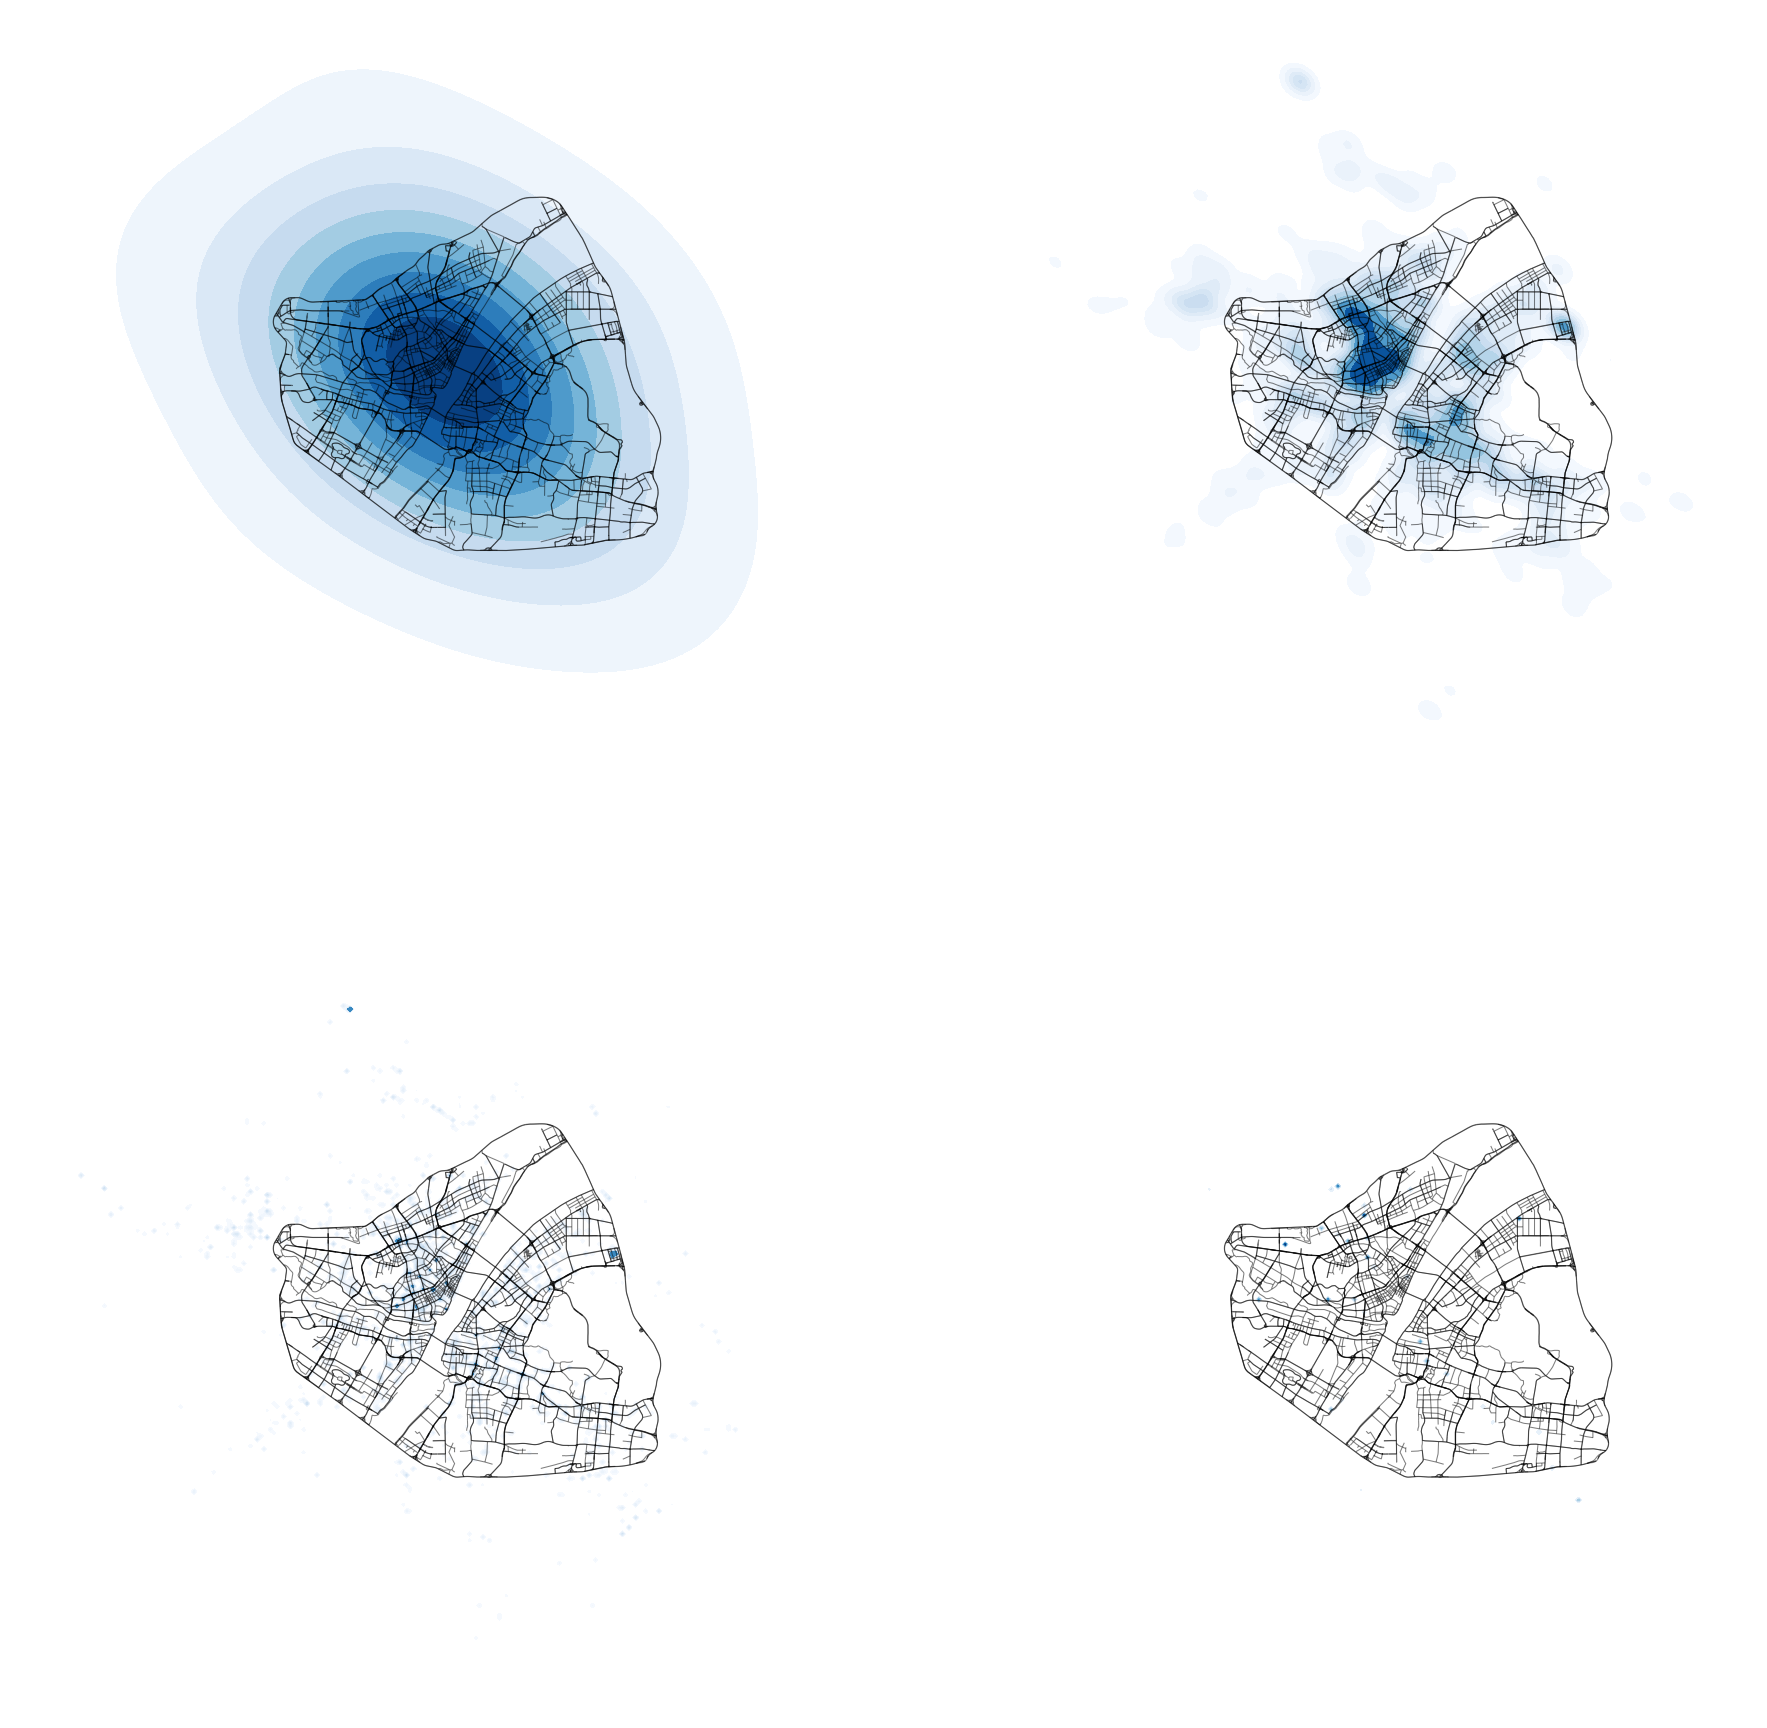

In [15]:
#kdeplot参数实验，不同带宽，平滑程度不同
plt.figure(figsize=(15,15), dpi=150)
ax=plt.subplot(2,2,1)
gplt.kdeplot(ax=ax,df=gdf_drop,cmap='Blues',shade=True,figsize=(20,20),bw=1)
wuhan_road.plot(ax=ax,linewidth = 0.5, alpha = 0.5, color = 'black')
ax=plt.subplot(2,2,2)
gplt.kdeplot(ax=ax,df=gdf_drop,cmap='Blues',shade=True,figsize=(20,20),bw=0.1)
wuhan_road.plot(ax=ax,linewidth = 0.5, alpha = 0.5, color = 'black')
ax=plt.subplot(2,2,3)
gplt.kdeplot(ax=ax,df=gdf_drop,cmap='Blues',shade=True,figsize=(20,20),bw=0.01)
wuhan_road.plot(ax=ax,linewidth = 0.5, alpha = 0.5, color = 'black')
ax=plt.subplot(2,2,4)
gplt.kdeplot(ax=ax,df=gdf_drop,cmap='Blues',shade=True,figsize=(20,20),bw=0.001)
wuhan_road.plot(ax=ax,linewidth = 0.5, alpha = 0.5, color = 'black')

可见，恰当的参数选择对KDE至关重要


*当然，由于上面使用全天的数据，使得上下车点的空间分布模式并不显著，核密度图也比较简单，这里建议选取部分轨迹（按照id或按照时间）进行尝试，下面有相关提取轨迹代码，可供参考*
* 实习2中我选取的新的实验对象为 *按照时间挑选的部分轨迹*   
即11月5日9-11时的所有轨迹



# 2.3 载客轨迹的聚类

    本节我们的聚类对象由上一节的轨迹OD点变成一条完整的载客轨迹。    
## 2.3.1 轨迹线相似性指标介绍
与轨迹点的聚类方法类似，轨迹线的聚类本质上也是对各条轨迹间的距离进行度量，并按照“相似相近”的原理进行分类。因此，实现轨迹线的距离前提是确定适当的指标以表征两条轨迹间相距远近，常用的指标有DTW距离和欧氏距离。
**欧氏距离**
欧氏距离的用法实际上同轨迹上下车点的欧氏距离测度方法一致，均是将轨迹视作一系列连续点集，分别计算对应两点的欧氏距离，原理如下图所示。

![](image/轨迹欧氏距离计算.png)

但这种方法有一个比较明显的缺点在于两个轨迹序列的样本点数目必须完全一致，但在我们通过GNSS定位获取的轨迹数据中很难保证这一点，因此欧氏距离法大多场景下无法使用。
***DTW（动态时间规整）距离***
欧式距离的一个明显的限制是要求两条轨迹长度相等，这在实际情况中是不太可能的，更理想的情况应该在轨迹长度上具有一定的灵活性。

动态时间归整DTW的思想是自动扭曲两个序列，并在时间轴上进行局部的缩放对齐，以使其形态尽可能一致，从而得到最大可能的相似性。DTW将两条轨迹的点进行多对多的映射，从而较为高效地解决了数据不齐的问题，其动态规划算法如下图所示。

![](image/轨迹DTW公式.png)

其算法的运行原理如下，其中上下两段轨迹点的数目是不同的。

![](image/DTW示意.png)

因此，本次实习主要考虑使用DTW算法度量两条轨迹的距离。
## 2.2.2 轨迹距离度量实验
本次实习聚类的轨迹为载客轨迹，因此需要在第一次实习的基础上提取出载客的轨迹并为每条轨迹分配一个唯一编号，处理方法是为loads轨迹列表中每个轨迹的DataFrame添加一列TID字段，同一条轨迹的TID是一致的。

我们需要为列表中的每个元素（DataFrame）添加一列，作为它们的ID。(已改）

In [16]:
loads_track = get_sub_trajectory(pd.read_csv('data/processed_1.txt'))[0]  # 载客轨迹是返回参数的第一个
reserved_tracks = []
track_id = 1
for i in range(0, len(loads_track)):
    if len(loads_track[i]) > 20:
        loads_track[i]['TID'] = track_id
        track_id += 1
        reserved_tracks.append(loads_track[i])
print(loads_track[0])
track_df_1110 = pd.concat(reserved_tracks)  # 所有DataFrame拼接为一个
track_df_1110.to_csv('data/Load_Tracks_1110_pro1.csv',index=False, encoding="utf_8_sig")  # 保存轨迹记录，方便后续调用

    出租车ID                 定位时间          经度         纬度   方向  速度 空车/重车
0    1015  2018-11-05 00:00:22  114.206137  30.610543  278  71    重车
1    1015  2018-11-05 00:00:28  114.204898  30.610702  276  72    重车
2    1015  2018-11-05 00:00:34  114.203683  30.610835  276  70    重车
3    1015  2018-11-05 00:00:34  114.203683  30.610835  276  70    重车
4    1015  2018-11-05 00:00:40  114.202515  30.610963  278  66    重车
5    1015  2018-11-05 00:00:46  114.201462  30.611160  282  65    重车
6    1015  2018-11-05 00:00:52  114.200277  30.611288  274  73    重车
7    1015  2018-11-05 00:00:57  114.199217  30.611433  278  74    重车
8    1015  2018-11-05 00:01:03  114.198118  30.611545  272  53    重车
9    1015  2018-11-05 00:01:18  114.196982  30.611655  276  16    重车
10   1015  2018-11-05 00:01:24  114.196883  30.611503  204  15    重车
11   1015  2018-11-05 00:01:35  114.196775  30.610513  184  48    重车
12   1015  2018-11-05 00:01:42  114.196498  30.609570  200  58    重车
13   1015  2018-11-05 00:01:49  11

下面我们将选择两条长度相同（具有一样的轨迹点数目）的轨迹，使用最基础的欧几里得距离方法，测度它们之间的轨迹距离：

In [17]:
t1 = [-1, 0]
t2 = [-1, 0]  # 挑选长度比较长的两条轨迹（长度相同）进行实验分析
track_counts = track_df_1110['TID'].value_counts()  # 按照编号统计轨迹点数
for k1, v1 in track_counts.items():
    t1 = [k1, v1]
    for k2, v2 in track_counts.items():
        t2 = [k2, v2]
        if k1 != k2 and v1 == v2: break  # 选到两条即可
    if k1 != k2 and v1 == v2: break  # 选到两条即可
Euclid_track1 = track_df_1110[track_df_1110['TID'] == t1[0]]
Euclid_track2 = track_df_1110[track_df_1110['TID'] == t2[0]]
t1_lat = Euclid_track1['纬度'].values  # 实际上就转化为每个轨迹中对应节点间的欧氏距离均值
t2_lat = Euclid_track2['纬度'].values
t1_lon = Euclid_track1['经度'].values
t2_lon = Euclid_track2['经度'].values
dis_tracks = np.sum(np.sqrt(np.square(np.array(t1_lat)-np.array(t2_lat)) + np.square(np.array(t1_lon)-np.array(t2_lon)))) / len(Euclid_track1)
print(dis_tracks)

0.13108120374440627


在欧氏距离表达轨迹间距时，我们使用了两条点数相同的轨迹，但实际上两条轨迹的点数完全一致的概率很低，大多数情况下我们在进行分类或其他的研究时所面对的轨迹点数是不一致的，造成欧氏距离测度的不可用。

此时，我们可选择DTW方法，从经纬度两个方向上对长度不一致的两个序列分别进行平滑，使它们尽可能规整，进而分别求出轨迹在两个方向上的偏移，以近似地表示一般情况下两条轨迹的间距。

计算任意两个时间序列的DTW距离的Python算法实现如下：

In [18]:
import numpy as np
def dtw_distance(ts_a, ts_b, d=lambda x,y: np.abs(x-y), mww=10000):
    """Computes dtw distance between two time series
    
    Args:
        ts_a: time series a
        ts_b: time series b
        d: distance function
        mww: max warping window, int, optional (default = infinity)
        
    Returns:
        dtw distance
    """
    
    # Create cost matrix via broadcasting with large int
    ts_a, ts_b = np.array(ts_a), np.array(ts_b)#numpy化
    M, N = len(ts_a), len(ts_b)
    cost = np.ones((M, N))

    # Initialize the first row and column
    cost[0, 0] = d(ts_a[0], ts_b[0])
    for i in range(1, M):
        cost[i, 0] = cost[i-1, 0] + d(ts_a[i], ts_b[0])

    for j in range(1, N):
        cost[0, j] = cost[0, j-1] + d(ts_a[0], ts_b[j])

    # Populate rest of cost matrix within window
    for i in range(1, M):
        for j in range(max(1, i - mww), min(N, i + mww)):
            choices = cost[i-1, j-1], cost[i, j-1], cost[i-1, j]
            cost[i, j] = min(choices) + d(ts_a[i], ts_b[j])

    # Return DTW distance given window 
    return cost[-1, -1]

我们以Euclid_track1和Euclid_track2两条轨迹为基础，保持前者不变，后者随机去掉中途的50个点，即使用如下方法处理两条轨迹。

In [19]:
import random as rd

dtw_track1 = Euclid_track1

def randomly_drop(s, drop_size):  # 对于序列s，实现随机丢弃其中的size个元素
    size = drop_size
    if drop_size >= len(s): size = 50
    drops = []
    for i in range(50): drops.append(rd.randint(1,len(s)-1))  # 随机产生需要删除的元素的索引
    drops = list(set(drops))
    dt2 = s.drop(s.index[drops])  # 去掉随机的50个点后的轨迹
    return dt2

dtw_track2 = randomly_drop(Euclid_track2, 50)
print('轨迹1的长度：' + str(len(dtw_track1)) + '\n轨迹2的长度：' + str(len(dtw_track2)))

轨迹1的长度：430
轨迹2的长度：384


In [20]:
dtw1_lat=dtw_track1['纬度']
dtw1_lon=dtw_track1['经度']
dtw2_lat=dtw_track2['纬度']
dtw2_lon=dtw_track2['经度']

此时，我们在原先长度相同的两条轨迹基础上获得了两条一般情况下的轨迹（长度不同），下面将以此为例，尝试应用DTW方法度量两条新轨迹的间距。

In [21]:

#使用fastdtw测试
import math
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import time

#计时
s=time.time()

dist_fast_lat, path1 = fastdtw(dtw1_lat, dtw2_lat, dist=euclidean)  # 分别在经度、纬度方向上计算两条轨迹的偏差
dist_fast_lon, path2 = fastdtw(dtw1_lon, dtw2_lon, dist=euclidean)
e=time.time()

print("代码运行耗时{}秒".format(e-s))
print(math.sqrt(dist_fast_lat ** 2 + dist_fast_lon ** 2))

代码运行耗时0.28228044509887695秒
37.13411103328171


In [22]:

#使用实现的dtw距离测试
import math
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

#计时
s=time.time()

# 如使用上面给出的DTW距离计算方法
dtw_distance_lat = dtw_distance(dtw1_lat, dtw2_lat)
dtw_distance_lon = dtw_distance(dtw1_lon, dtw2_lon)
e=time.time()

print("代码运行耗时{}秒".format(e-s))

print(math.sqrt(dist_fast_lat ** 2 + dist_fast_lon ** 2))

代码运行耗时0.7330389022827148秒
37.13411103328171


### 对比可知fastDTW速度更快，且两者计算的结果几乎无差别

Reference：https://www.cnblogs.com/kemaswill/archive/2013/04/18/3029078.html  

  FastDTW综合使用限制和数据抽象两种方法来加速DTW的计算，主要分为三个步骤：

  (1). 粗粒度化。亦即首先对原始的时间序列进行数据抽象，数据抽象可以迭代执行多次1/1->1/2->1/4->1/16，粗粒度数据点是其对应的多个细粒度数据点的平均值。

  (2). 投影。在较粗粒度上对时间序列运行DTW算法。

  (3). 细粒度化。将在较粗粒度上得到的归整路径经过的方格进一步细粒度化到较细粒度的时间序列上。除了进行细粒度化之外，还额外的在较细粒度的空间内额外向外(横向，竖向，斜向)扩展K个粒度，K为半径参数，一般取为1或者2.

## 2.2.2 轨迹聚类实验

我们在2.1节中也进行了聚类的研究，其聚类的对象是出租车轨迹中的OD点。

本节我们将继续探究出租车轨迹中的聚类方法，与之前内容不同的是，此处我们的聚类对象不在是简单的点要素，而变成了更加复杂的轨迹线要素（多点构成的点序列）。聚类的方法本质上没有改变，仍是基于传统的DBSCAN或K-means等聚类方法。相关代码的实现包含以下几个要点：

1. 选定聚类模型：基于层次聚类基于密度聚类或基于划分聚类。

2. 构造距离矩阵：求任意两个对象的距离，构成距离矩阵。

3. 将距离矩阵按照所选模型把各个元素划分至不同类别。

在本次实习中，由于我们无法预先确定轨迹类数大致的范围，但可以求取两两轨迹间任意的距离，因此该次任务中使层次聚类方法进行聚类。其他经典算法如DBSCAN、K-means等聚类模型也可以采用，感兴趣者可尝试自行搜索学习相关的模型方法，并应用到轨迹的聚类上。

因此，接下来需要采取OD点聚类时类似的操作，基于出租车轨迹间距构造距离矩阵。

* 本次实习的出租车轨迹采样间隔约15秒，而出租车平均出行时长通常超过10分钟，很少有3、4分钟的极端时间行程，因此我们对于少于20点的轨迹在聚类过程中不予考虑。

首先，筛选符合条件的轨迹并提取经纬度坐标数组：

* 由于我们在构建DataFrame时排除了数目小于20的轨迹，可直接用track_df_1110中的轨迹进行实验。

In [23]:


def select_cars(car_ids, size):  # 选取一定数量的出租车一天中的所有轨迹，降低数据运算开销
    selected_indexs = []
    for i in range(size): selected_indexs.append(rd.randint(0,len(car_ids)-1))  # 随机产生需要删除的元素的索引
    selected_indexs = list(set(selected_indexs))
    selected_car_ids = [car_ids[i] for i in selected_indexs]
    return selected_car_ids

def get_selected_track_df(tdf, selected_ids):  # 根据抽取的出租车ID精简DataFrame
    selected_dfs = []
    for ids in selected_ids: selected_dfs.append(tdf[tdf['出租车ID'] == ids])
    selected_tracks =  pd.concat(selected_dfs)  # 重新生成筛选后的轨迹DataFrame
    return selected_tracks


'''由于原始的数据比较大，因此我们在此处抽取15辆车的轨迹作为示例'''
reserved_cars = []  # 保留的车辆ID
car_IDs = track_df_1110['出租车ID'].unique().tolist()#所有的car id

selected_car_IDs = select_cars(car_IDs, 10)#目前选取十辆车
print(selected_car_IDs)
selected_tracks_by_car_id = get_selected_track_df(track_df_1110, selected_car_IDs)
print(selected_tracks_by_car_id)

[820, 35335, 1270, 35424, 362, 364, 5500, 31341, 638]
        出租车ID                 定位时间          经度         纬度   方向  速度 空车/重车   TID
316614    820  2018-11-05 00:56:07  114.262398  30.580085  156  20    重车  1761
316615    820  2018-11-05 00:56:37  114.262953  30.579165  166  12    重车  1761
316616    820  2018-11-05 00:56:49  114.263370  30.578218  168  34    重车  1761
316617    820  2018-11-05 00:56:59  114.263473  30.577412  178  12    重车  1761
316618    820  2018-11-05 00:57:18  114.263678  30.577462   24  17    重车  1761
...       ...                  ...         ...        ...  ...  ..   ...   ...
283819    638  2018-11-05 21:38:57  114.263610  30.624833  336  60    重车  1569
283820    638  2018-11-05 21:39:27  114.261235  30.628348   14  40    重车  1569
283821    638  2018-11-05 21:39:36  114.261410  30.629305   10  41    重车  1569
283822    638  2018-11-05 21:39:45  114.262562  30.629598   50  32    重车  1569
283823    638  2018-11-05 21:41:05  114.267575  30.631298   66  29    重车  156

In [24]:
pd.DataFrame(selected_tracks_by_car_id)

,出租车ID,定位时间,经度,纬度,方向,速度,空车/重车,TID
316614,820,2018-11-05 00:56:07,114.262398,30.580085,156,20,重车,1761
316615,820,2018-11-05 00:56:37,114.262953,30.579165,166,12,重车,1761
316616,820,2018-11-05 00:56:49,114.263370,30.578218,168,34,重车,1761
316617,820,2018-11-05 00:56:59,114.263473,30.577412,178,12,重车,1761
316618,820,2018-11-05 00:57:18,114.263678,30.577462,24,17,重车,1761
...,...,...,...,...,...,...,...,...
283819,638,2018-11-05 21:38:57,114.263610,30.624833,336,60,重车,1569
283820,638,2018-11-05 21:39:27,114.261235,30.628348,14,40,重车,1569
283821,638,2018-11-05 21:39:36,114.261410,30.629305,10,41,重车,1569
283822,638,2018-11-05 21:39:45,114.262562,30.629598,50,32,重车,1569


In [25]:
import time

def random_select_tracks(tracks, size):  # 由于原有的轨迹数据量太大（近60,000条），计算时间过长，选取其中1,000条轨迹
    len_tracks = len(tracks)
    selected = []
    for i in range(int(1.05 * size)): selected.append(rd.randint(1,len(tracks)-1))  # 随机产生选取的轨迹
    selected = list(set(selected))  # 确定抽样的轨迹ID
    selected_tracks = [tra for tra in tracks if tra['id'] in selected]  # 随机抽取轨迹
    return selected_tracks

def get_track_coords(tdf, tIDs):
    tracks = []  # 存放轨迹中各点的经纬度坐标序列
    new_id = 1
    for ids in tIDs:
        if ids % 1000 == 0:print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
        track_lons = tdf[tdf['TID'] == ids]['经度'].values.tolist()
        track_lats = tdf[tdf['TID'] == ids]['纬度'].values.tolist()
        tracks.append({'id':new_id, 'taxi': tdf[tdf['TID'] == ids]['出租车ID'].values.tolist()[0], 'track_id': ids,
                       'start':tdf[tdf['TID'] == ids]['定位时间'].values.tolist()[0], 'coords': [track_lons, track_lats]})  # 重新为选取的轨迹编号
        new_id += 1
    return tracks

def np_dtw_matrix(dataset):
    N = len(dataset)
    res = np.zeros((N,N),dtype='float32')
    for i in range(N):
        if i % 50 == 0: print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))  # 较多时间用于动态得求出两条一般的轨迹的间距
        for j in range(i+1, N):
            dis_lon, _ = fastdtw(dataset[i]['coords'][0], dataset[j]['coords'][0], dist=euclidean)
            dis_lat, _ = fastdtw(dataset[i]['coords'][1], dataset[j]['coords'][1], dist=euclidean)
            res[i,j] = math.sqrt(dis_lat**2 + dis_lon**2)
            res[j,i] = res[i,j]  # 通过求解矩阵的一半来加快部分运行的效率
    return res 

In [26]:
tIDs = selected_tracks_by_car_id['TID'].unique().tolist()  # 数据集中所有轨迹的ID
track_coords_1110 = get_track_coords(selected_tracks_by_car_id, tIDs)
print(len(track_coords_1110)) 

236


In [27]:
dtw_matr = np_dtw_matrix(track_coords_1110)
print(dtw_matr)

2021-06-14 05:42:26
2021-06-14 05:50:59
2021-06-14 05:57:20
2021-06-14 06:01:40
2021-06-14 06:04:35
[[ 0.          2.4123926   5.95884    ...  2.9561038   3.8481612
   0.47497097]
 [ 2.4123926   0.          5.261796   ...  5.5084      6.20804
   2.7799587 ]
 [ 5.95884     5.261796    0.         ... 11.974148   12.6645775
   7.044293  ]
 ...
 [ 2.9561038   5.5084     11.974148   ...  0.          1.9042996
   1.334468  ]
 [ 3.8481612   6.20804    12.6645775  ...  1.9042996   0.
   1.913666  ]
 [ 0.47497097  2.7799587   7.044293   ...  1.334468    1.913666
   0.        ]]


现在我们已经获取了表示两两轨迹之间的距离矩阵，可以开始进行聚类。前面我们已经提到使用层次聚类对我们计算得到的距离矩阵进行分割，需要用到Python中的Scipy工具包，在第一次实习任务中我们已安装了scipy工具包（集成在Anaconda中），我们引入并利用其中集成好的层次聚类算法模型：


In [28]:
import scipy
import scipy.cluster.hierarchy as sch
#import fastcluster as fc

#层次聚类算法参数不同，结果不同，主要可以调节的有linkage,criterion


Z1 = sch.linkage(dtw_matr,method='average') 
print("method='average'","criterion='inconsistent'")
cluster1= sch.fcluster(Z1, t=1, criterion='inconsistent') 
print(cluster1)
print('聚类数:',len(set(cluster1.tolist())))

print('++++++++++++++++++++++++++++++++++\n')
print("method='ward'","criterion='maxclust'")# 限制了最大聚类数的层次聚类
Z2 = sch.linkage(dtw_matr,method='ward') 
cluster2= sch.fcluster(Z2, t=15, criterion='maxclust') 
print(cluster2)
print('聚类数:',len(set(cluster2.tolist())))

method='average' criterion='inconsistent'
[28 42  8 66 66 70  4 40 19 13  5 37 22 36 38 15 16 17 13 12 12  6 70 35
 50 49 63 52 47 46 50 25 50 46 21 22 70 70  6 11 39 35 39 11 39 21 19 26
 24 14 12 48 49 57 56 67 53 53 45 25 24 29 30 33 33 29 67 70 43 31 27 35
 39  9 60  8 44 54 57 56  1  1 63 32 27  9 35 35 50 62  8 43 39 44 32 63
 56 55 66 51 70 68 66 65 68 67 64 61 56 66 59  8 62 46 54 58 10  4  8  8
 61 39 50 55 58 55 44 23  6  2  2 32 28 39  2  6 42 44 40 43 34 43 44 16
  6  3 18 38 34 31 29  9 62 69  1  8  3  3  3 63 66 70 52 64 59 41 70 55
 70  7 41 61 53 38 63 62 48 65 66 53 50 45 59 70  1  1 68 68 66 66 49 45
  9 61  6 39  2 19 18 38 15  5 22 25 32 26 35 35 17 63 70  1 25 25 16 18
 36 26 28 28 37 36 47 57 51  8 32 32  6 39 33 63 21 17 20 26]
聚类数: 70
++++++++++++++++++++++++++++++++++

method='ward' criterion='maxclust'
[ 8  8  9 15 15  4 11 11  7  7 10  8  7  8  8  8  8  7  7  7  7 10  4  8
 12 12 13 12 12 12 12  8 12 12  8  7  4  4 10  8  8  8  8  8  8  8  7  8
  8  7  7 12 1

<ipython-input-28-3cdf22f24171>:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z1 = sch.linkage(dtw_matr,method='average')
<ipython-input-28-3cdf22f24171>:16: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z2 = sch.linkage(dtw_matr,method='ward')


In [29]:
'''将分类的标签赋予对应的轨迹'''
print(len(cluster1.tolist()))
for i in range(0, len(track_coords_1110)):track_coords_1110[i]['cluster'] = cluster1.tolist()[i]  # 此处以未限定最大分类数的聚类结果数的情况作为示例
# print(track_coords_1110[1])

236


现在我们已经按照确定的类数为轨迹划分了类别，但此处仍然存在一个问题，即我们在层次聚类中为数据集指定了最大的分类数目，但是我们并没有办法预知聚类的主要参数（例如聚类的数目）。这是目前聚类中一个比较关键且难以解决的问题，如K-means聚类方法中我们同样比较难获取聚类的参数。

针对这些聚类参数选择方法，有许多相关研究，如手肘法、轮廓系数法等，在K-means等聚类模型中都有应用，感兴趣者可搜索并学习相关优化方法，比较应用前后聚类效果的差异。

层次聚类是相对各聚类算法中指定参数复杂性较低的一种模型，虽然也可限定最大聚类数目，但也可用距离、相似度等容易理解的判别方式进行聚类。



### 轮廓系数法确定最大聚类数

In [30]:
import sklearn.metrics as sm
possible=range(5,len(track_coords_1110)-1)
sils=[]
for i in possible:
    Z = sch.linkage(dtw_matr,method='ward') #层次聚类
    cluster= sch.fcluster(Z, t=i, criterion='maxclust') 
    
    silhouette_score = sm.silhouette_score(dtw_matr, cluster, sample_size=len(dtw_matr), metric='euclidean')
    sils.append(silhouette_score)
print('最佳聚类数为：',possible[sils.index(max(sils))])

<ipython-input-30-f2ffd70d8a3b>:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = sch.linkage(dtw_matr,method='ward') #层次聚类
<ipython-input-30-f2ffd70d8a3b>:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = sch.linkage(dtw_matr,method='ward') #层次聚类
<ipython-input-30-f2ffd70d8a3b>:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = sch.linkage(dtw_matr,method='ward') #层次聚类
<ipython-input-30-f2ffd70d8a3b>:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = sch.linkage(dtw_matr,method='ward') #层次聚类
<ipython-input-30-f2ffd70d8a3b>:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation 

最佳聚类数为： 14


<ipython-input-30-f2ffd70d8a3b>:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = sch.linkage(dtw_matr,method='ward') #层次聚类
<ipython-input-30-f2ffd70d8a3b>:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = sch.linkage(dtw_matr,method='ward') #层次聚类
<ipython-input-30-f2ffd70d8a3b>:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = sch.linkage(dtw_matr,method='ward') #层次聚类
<ipython-input-30-f2ffd70d8a3b>:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = sch.linkage(dtw_matr,method='ward') #层次聚类


### WB-index 法 & Xu-index 法确定聚类数

In [31]:
import scipy
import scipy.cluster.hierarchy as sch

def ssw_ssb(dtw_matr,cluster):
    m=list(set(cluster))
    ssw=99999999
    sswt=0
    ssb=0
    for i in m:
        idx1 = [c for c in range(len(cluster)) if cluster[c] == i]
        if len(idx1)==1:
            sswt+=1
        else:
            for p in idx1:
                for q in idx1:
                    if p!=q:
                        if dtw_matr[p,q]<ssw:#求最小值（类内差距最小）
                            ssw=dtw_matr[p,q]
        for j in m:
            idx2 = [c for c in range(len(cluster)) if cluster[c] == j]
            for p in idx1:
                for q in idx2:
                    if dtw_matr[p,q]>ssb:#求最大值（类间差距最大）
                        ssb=dtw_matr[p,q]
        return 1-ssw+sswt,1-ssb
def wbindex(ssw,ssb,m):
    m=float(m)
    return m*ssw/ssb
wbs=[]
possible=range(25,len(track_coords_1110))#可能的聚类数
for i in possible:
    Z = sch.linkage(dtw_matr,method='ward') #层次聚类
    cluster= sch.fcluster(Z, t=i, criterion='maxclust') 
#     print(cluster)
    ssw,ssb=ssw_ssb(dtw_matr,cluster.tolist())
    wb=wbindex(ssw,ssb,i)
#     print(wb)
    wbs.append(wb)
    
print('最佳聚类数为：',possible[wbs.index(min(wbs))])

<ipython-input-31-f990a3075f51>:32: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = sch.linkage(dtw_matr,method='ward') #层次聚类


最佳聚类数为： 25


In [32]:
def chindex(ssw,ssb,m,n):
    m=float(m)
    return ((ssb/m)-1)/(ssw/n-m)

chs=[]
possible=range(2,len(track_coords_1110))#可能的聚类数
for i in possible:
    Z = sch.linkage(dtw_matr,method='ward') #层次聚类
    cluster= sch.fcluster(Z, t=i, criterion='maxclust') 
#     print(cluster)
    ssw,ssb=ssw_ssb(dtw_matr,cluster.tolist())
    ch=chindex(ssw,ssb,i,len(track_coords_1110))
#     print(ch)
    chs.append(ch)
print('最佳聚类数为：',possible[chs.index(max(chs))])

<ipython-input-32-246d46f2f016>:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = sch.linkage(dtw_matr,method='ward') #层次聚类


最佳聚类数为： 2


下面我们将统计聚类中出现频率最高的轨迹，对这些频繁轨迹进行可视化。

<AxesSubplot:>

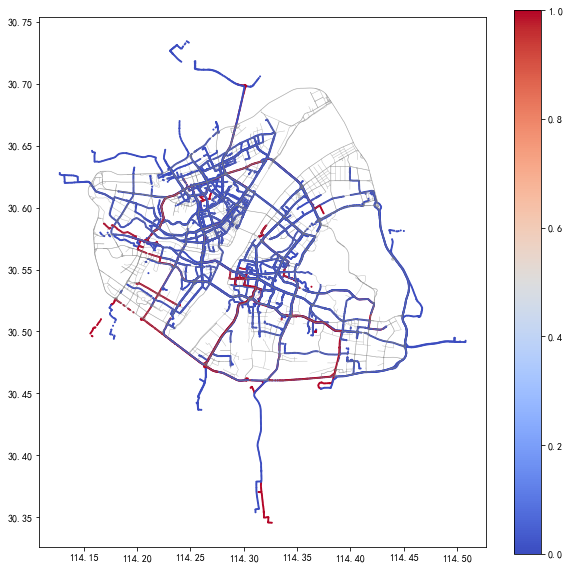

In [34]:
import geopandas as gpd
import matplotlib.pyplot as plt


def get_frequent_track(labels, track_dicts, tdf):  # 统计聚类中出现最频繁的轨迹类型，将其通过标记字段与其他类型轨迹区分开
    max_label = max(labels, key=labels.count)  # 统计频繁轨迹所属的类    
    frequent_TID = [track_dicts[i]['track_id'] for i in range(0, len(track_dicts)) if track_dicts[i]['cluster'] == max_label]  # 统计频繁轨迹ID（TID）
    tdf['frequency'] = 0
    new_df = tdf
    for ids in frequent_TID: new_df.loc[(new_df.TID == ids), 'frequency'] = 1  # 频繁轨迹的frequency字段值为1，非频繁轨迹的frequency字段值为0
    return new_df

frequent_tracks_df = get_frequent_track(cluster1.tolist(), track_coords_1110 , selected_tracks_by_car_id)  # 在实验轨迹数据中标记出聚类所得的频繁轨迹
'''使用geopandas可视化出租车轨迹的方法我们在上次实习中已经涉及，此处同样还需用到'''
#首先是转成GeoDataFrame
frequent_gdf = gpd.GeoDataFrame(frequent_tracks_df, geometry=gpd.points_from_xy(frequent_tracks_df['经度'], frequent_tracks_df['纬度']))
#其次是调用自带的plot函数，选定颜色依赖列，这里显然得是frequency字段，标识是否是频繁轨迹中的轨迹点
track_ax = frequent_gdf.plot(column='frequency',cmap='coolwarm',legend=True,markersize=1,figsize=(10,10))  # 必要的绘图设置
wuhan_road = gpd.GeoDataFrame.from_file('data/road/WHroad.shp')  # 叠加武汉市路网
wuhan_road.plot(ax = track_ax, linewidth = 0.5, alpha = 0.5, color = 'grey')

In [35]:
pingfan=frequent_gdf[frequent_gdf['frequency']==1]# 提取频繁轨迹

In [36]:
import folium
import webbrowser
import geopandas as gpd
wh = folium.Map(location=[30.5928,114.3055], zoom_start=12)

folium.Marker(
  location=[np.mean(pingfan['纬度']), np.mean(pingfan['经度'])],
    popup='mean center',
).add_to(wh)


folium.Marker(
  location=[np.median(pingfan['纬度']), np.median(pingfan['经度'])],
    popup='median center',
).add_to(wh)
display(wh)

### 将频繁轨迹均值中心和中位数中心加入地图上  
通过地图观察周边社会地理环境，我们可以发现：
* 附近居民小区数目比较多，如“景虹花园”、“康乐苑”等，具有生活居住的功能；
* 该区域紧邻学校（大中小学）、医院，频繁轨迹可能是因为看病、上下学所致
* 该区域还分布有一定数量的餐饮商铺，综合前两点，这类频繁轨迹主要是解决该生活区内短途的生活、休闲需要。


## 2.2.3 轨迹聚类的应用场景
### 2.2.3.1 应用场景简介
轨迹聚类在社会空间计算特别是与交通地理分析相关的研究中有着比较广泛的应用，例如：
* 利用轨迹聚类算法找出车辆轨迹热点区域对交通部门规划管理交通出行有重要指导意义(王侃, 梅克进, 朱家辉, 牛新征. 基于时空轨迹的热点区域提取[J]. 电子科技大学学报, 2019, 48(6): 925-930.)；
* 轨迹模式，无论是行车模式抑或是飞行器的飞行模式，对理解和判断目标在一段时间或一定区域内的行为有着重要的意义，不仅能够分析正常情况下的特征与规律，还能够从异常的模式中学习到相关的关键特征，为预防事故发生做出一定的贡献；(郭威,唐慧丰.基于轨迹聚类的航空器轨迹模式挖掘研究[J].计算机应用研究,2020,37(02):416-420.)
* 下一位置点预测，即通过出租车的轨迹类型标识以及轨迹的经纬度坐标，预测出租车后续的位置点，如预测出租车的Destination (BESSE, Philippe C., GUILLOUET, Brendan, LOUBES, Jean-Michel, et al. Destination Prediction by Trajectory Distribution-Based Model. IEEE Transactions on Intelligent Transportation Systems, 2017.)。

### 2.2.3.2 出租车Destination预测方法简介


为了演示轨迹预测的效果，我们抽取一部分起始点在广埠屯附近的轨迹

In [37]:
import pandas as pd
import geopandas as gpd
df=pd.read_csv('data/processed_1.txt')
sub_df=pd.DataFrame()

n=32#抽取的轨迹数目
c=0#轨迹计数编号

#广埠屯坐标
clat=30.5266
clng=114.3535
# 武汉大学经纬度
# 30.5360° N, 114.3643° E
# 黄鹤楼经纬度
# clat=30.5445
# clng=114.3024

# 对所有的出租车
for tid in set(df['出租车ID']):
    df1=df[df['出租车ID']==tid].reset_index(drop=True)
    loads,no_loads,pick_up,drop_off=get_sub_trajectory(df1)#轨迹分段
    for trac in loads:
        trac=trac.reset_index(drop=True)
        lat=float(trac.iloc[0]['纬度'])
        lng=float(trac.iloc[0]['经度'])
        if abs(lat-clat)<0.01 and abs(lng-clng)<0.01 and len(trac)>10:#起点在广埠屯附近
            trac['TID']=c
            sub_df=sub_df.append(trac)
            c+=1
            print(lat,lng)
        if c==n:
            break
    if c==n:
        break

print(sub_df)

30.528497 114.349562
30.527307 114.354163
30.526465 114.356518
30.516642 114.363167
30.527833 114.350877
30.527658 114.351655
30.530523 114.348252
30.530192 114.34406
30.53372 114.34934
30.518905 114.362838
30.527662 114.352643
30.531078 114.359133
30.525565 114.35765
30.528135 114.351017
30.520368 114.363483
30.522118 114.345155
30.527417 114.352675
30.517545 114.362867
30.52732 114.345893
30.528262 114.349523
30.528663 114.348852
30.529057 114.348802
30.529708 114.346035
30.529928 114.34498
30.530025 114.345333
30.52914 114.347878
30.528562 114.3479
30.53571 114.350327
30.532352 114.359657
30.525225 114.357772
30.531992 114.362332
30.526425 114.347035
     出租车ID                 定位时间          经度         纬度   方向  速度 空车/重车  TID
0    35335  2018-11-05 00:00:22  114.349562  30.528497  288  55    重车    0
1    35335  2018-11-05 00:00:29  114.348517  30.528787  288  51    重车    0
2    35335  2018-11-05 00:00:37  114.347452  30.529023  284  47    重车    0
3    35335  2018-11-05 00:00:45  114.3

轨迹数： 32


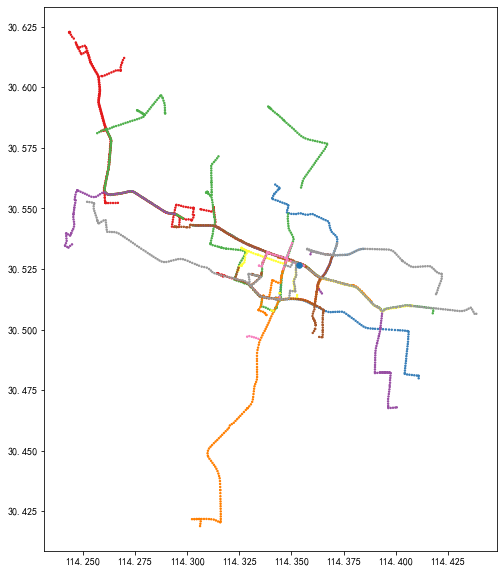

In [38]:
sub_df=sub_df.reset_index(drop=True)

# 可视化查看这些轨迹
gdf1 = gpd.GeoDataFrame(
    sub_df, geometry=gpd.points_from_xy(sub_df['经度'], sub_df['纬度']),crs=4326)
ax=gdf1.plot(column='TID',markersize=2,figsize=(10,10),cmap='Set1')
station=gpd.GeoDataFrame(geometry=gpd.points_from_xy([clng],[clat]), crs=4326)
station.plot(ax=ax,markersize=30)#可视化起点
print('轨迹数：',len(set(sub_df['TID'])))

进行轨迹聚类

In [39]:
import scipy
import scipy.cluster.hierarchy as sch

import math
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

tIDs = sub_df['TID'].unique().tolist()

# 分出一个测试轨迹
track_coords= get_track_coords(sub_df, tIDs[:-1])#取除去最后一条轨迹的所有轨迹
test_track_coords= get_track_coords(sub_df, tIDs[-1:])#取最后一条轨迹做测试

#构建DTW距离矩阵为接下来聚类模型做准备
dtw_matr2 = np_dtw_matrix(track_coords)
print(dtw_matr2)


2021-06-14 06:05:33
2021-06-14 06:05:33
[[ 0.         17.438347    8.908777   27.589806   30.737488   37.806087
  38.707363   12.942665    7.454622   30.445045   41.24405    40.65326
  45.92866     9.464432   33.481544   33.61091    35.03475    44.602184
  26.99617    39.36286    34.073883   36.970848   29.845879   29.642864
  15.631968   30.959044   29.946415   35.09575    40.179214   44.821217
  42.277733  ]
 [17.438347    0.          1.8519152   1.6519371   1.7905829   2.5836241
   5.934954   13.290809    2.6652315   1.1166158   4.7032566   2.7836826
   7.6043744   4.2472024   9.762895    1.8449506   1.6873095   3.6132991
   0.70398396  3.9349887   1.664973    2.29379     1.2940556   2.901401
   0.27194902  1.0530624   1.1699041   1.7441494   2.697796    6.276445
   5.2456565 ]
 [ 8.908777    1.8519152   0.          3.7455695   4.9852767   6.435158
   9.40349    14.657747    0.62951636  4.055369    8.632895    6.9057026
  11.413335    0.8797976  10.925843    4.868484    5.1791773   

In [40]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

<Figure size 18000x18000 with 0 Axes>

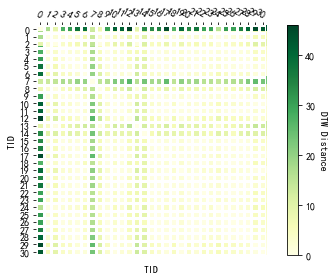

In [42]:
# 可视化DTW距离矩阵

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
vegetables = tIDs[:-1]
farmers = tIDs[:-1]
harvest = dtw_matr2
plt.figure(dpi=600,figsize=(30,30))

fig, ax = plt.subplots()
im, cbar = heatmap(harvest, vegetables, farmers, ax=ax,
                 cmap="YlGn",cbarlabel="DTW Distance")

plt.ylabel('TID')
plt.xlabel('TID')

fig.tight_layout()
plt.savefig('DTW_matr.jpg',dpi=600)
plt.show()

<ipython-input-48-5d2e2fd6fb91>:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z1 = sch.linkage(dtw_matr2,method='average')


[11  2  1  6  6  7  3 11  1  6  9  8  3  1 10  5  4  9  6  9  5  7  6  6
  2  6  6  4  8  3  3]
11


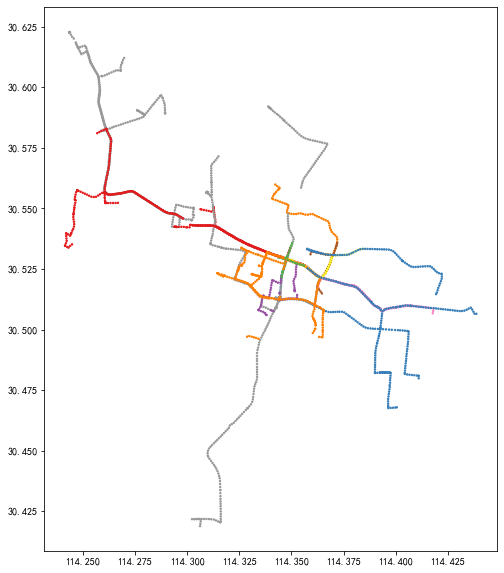

In [48]:
#层次聚类
Z1 = sch.linkage(dtw_matr2,method='average') 
#print(Z1)
cluster1= sch.fcluster(Z1, t=1, criterion='inconsistent') 
print(cluster1)
print(len(set(cluster1.tolist())))

for i in range(0, len(track_coords)):track_coords[i]['cluster'] = cluster1.tolist()[i] 
for label in cluster1.tolist():
    #统计每一类中有哪些轨迹
    tids=[track_coords[i]['track_id'] for i in range(0, len(track_coords)) if track_coords[i]['cluster'] == label] 
    for ids in tids: sub_df.loc[(sub_df.TID == ids), 'cluster'] = label #增加聚类标签
        

sub_df2=sub_df[sub_df['cluster']<=len(set(cluster1.tolist()))]#为了除去标签为nan的点（测试轨迹点）
gdf1 = gpd.GeoDataFrame(
    sub_df2, geometry=gpd.points_from_xy(sub_df2['经度'], sub_df2['纬度']),crs=4326)
#轨迹聚类结果可视化
ax=gdf1.plot(column='cluster',markersize=2,figsize=(10,10),cmap='Set1')

计算测试轨迹到各个类的距离，以此估计测试轨迹归属类

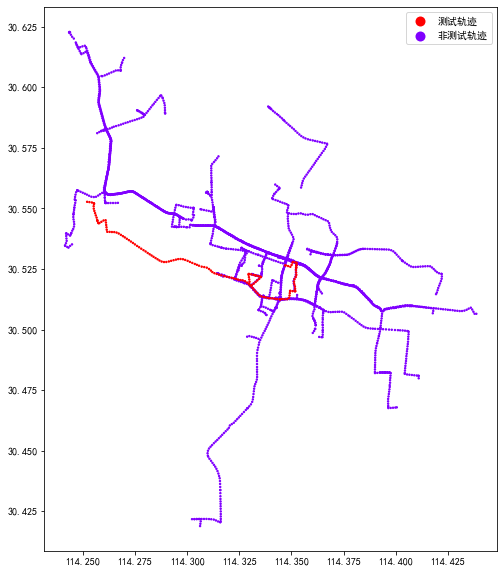

In [49]:
N=len(track_coords)
clist=cluster1.tolist()
N2=len(set(clist))# 潜在目的地数目
res = np.zeros((1,N2),dtype='float32')
res_cnt=np.zeros((1,N2),dtype='float32')
#思路是计算测试轨迹与各轨迹聚类的接近程度（如果测试轨迹与某一类中各轨迹的DTW距离均值最小，则是最接近）
for i in range(N):
    dis_lon, _ = fastdtw(track_coords[i]['coords'][0], test_track_coords[0]['coords'][0], dist=euclidean)
    dis_lat, _ = fastdtw(track_coords[i]['coords'][1], test_track_coords[0]['coords'][1], dist=euclidean)
    
    res[0,clist[i]-1] += math.sqrt(dis_lat**2 + dis_lon**2)#这里的值衡量了测试轨迹是该目的地的可能性（越小可能性越大）
    res_cnt[0,clist[i]-1] += 1#该目的地对应的类中轨迹的数目
    
#求均值排除不同类中轨迹数目不同带来的干扰
res=res/res_cnt
c=res.tolist()[0].index(min(res.tolist()[0]))+1#估计的目的地

#将测试轨迹划入最接近的类
sub_df['cluster']=c
sub_df['test']='测试轨迹'
for label in cluster1.tolist():
    tids=[track_coords[i]['track_id'] for i in range(0, len(track_coords)) if track_coords[i]['cluster'] == label] 
    for ids in tids: 
        sub_df.loc[(sub_df.TID == ids), 'cluster'] = label
        sub_df.loc[(sub_df.TID == ids), 'test']= '非测试轨迹'
gdf2 = gpd.GeoDataFrame(
    sub_df, geometry=gpd.points_from_xy(sub_df['经度'], sub_df['纬度']),crs=4326)
ax=gdf2.plot(column='test',markersize=2,figsize=(10,10),cmap='rainbow_r',legend=True)
# print('轨迹被划分至第',c,'类')

轨迹被划分至第 1 类


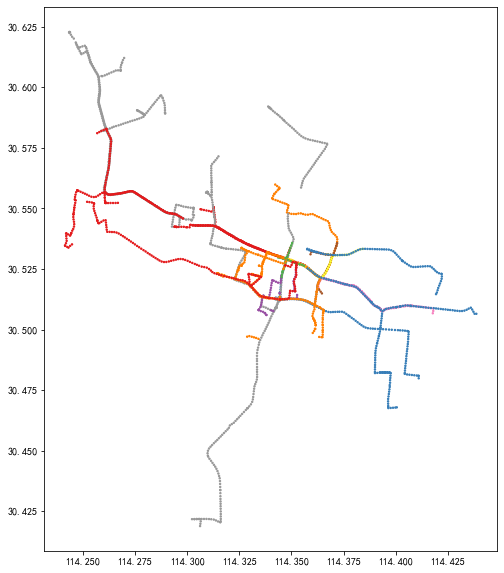

In [50]:
N=len(track_coords)
clist=cluster1.tolist()
N2=len(set(clist))# 潜在目的地数目
res = np.zeros((1,N2),dtype='float32')
res_cnt=np.zeros((1,N2),dtype='float32')
#思路是计算测试轨迹与各轨迹聚类的接近程度（如果测试轨迹与某一类中各轨迹的DTW距离均值最小，则是最接近）
for i in range(N):
    dis_lon, _ = fastdtw(track_coords[i]['coords'][0], test_track_coords[0]['coords'][0], dist=euclidean)
    dis_lat, _ = fastdtw(track_coords[i]['coords'][1], test_track_coords[0]['coords'][1], dist=euclidean)
    
    res[0,clist[i]-1] += math.sqrt(dis_lat**2 + dis_lon**2)#这里的值衡量了测试轨迹是该目的地的可能性（越小可能性越大）
    res_cnt[0,clist[i]-1] += 1#该目的地对应的类中轨迹的数目
    
#求均值排除不同类中轨迹数目不同带来的干扰
res=res/res_cnt
c=res.tolist()[0].index(min(res.tolist()[0]))+1#估计的目的地

#将测试轨迹划入最接近的类
sub_df['cluster']=c
for label in cluster1.tolist():
    tids=[track_coords[i]['track_id'] for i in range(0, len(track_coords)) if track_coords[i]['cluster'] == label] 
    for ids in tids: sub_df.loc[(sub_df.TID == ids), 'cluster'] = label
gdf2 = gpd.GeoDataFrame(
    sub_df, geometry=gpd.points_from_xy(sub_df['经度'], sub_df['纬度']),crs=4326)
ax=gdf2.plot(column='cluster',markersize=2,figsize=(10,10),cmap='Set1')
print('轨迹被划分至第',c,'类')

### 确定测试轨迹归属类后，用该类（除测试轨迹外）的所有轨迹的D点算数平均值预测测试轨迹的D点

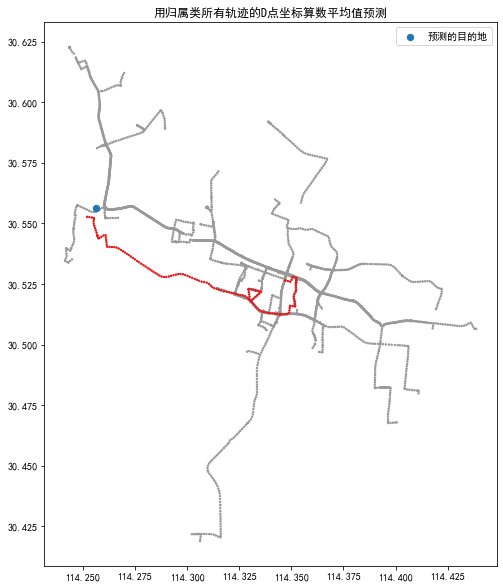

In [52]:
import matplotlib.pyplot as plt
plt.rcParams['font.family']=['SimHei']



all_dests=gdf1.groupby(['cluster',"TID"]).last()[['经度','纬度']].mean(level="cluster")
all_dests=all_dests.reset_index()
dst_lon=all_dests[all_dests['cluster']==c]['经度']
dst_lat=all_dests[all_dests['cluster']==c]['纬度']

gdf2 = gpd.GeoDataFrame(
    sub_df, geometry=gpd.points_from_xy(sub_df['经度'], sub_df['纬度']),crs=4326)
ax=gdf2.plot(column='test',markersize=2,figsize=(10,10),cmap='Set1')
dst=gpd.GeoDataFrame(geometry=gpd.points_from_xy([dst_lon],[dst_lat]), crs=4326)
dst.plot(ax=ax,markersize=40,label='预测的目的地')#可视化预测的目的地
plt.title('用归属类所有轨迹的D点坐标算数平均值预测')
plt.legend()

### 确定测试轨迹归属类后，用该类（除测试轨迹外）的所有轨迹的D点中位数预测测试轨迹的D点

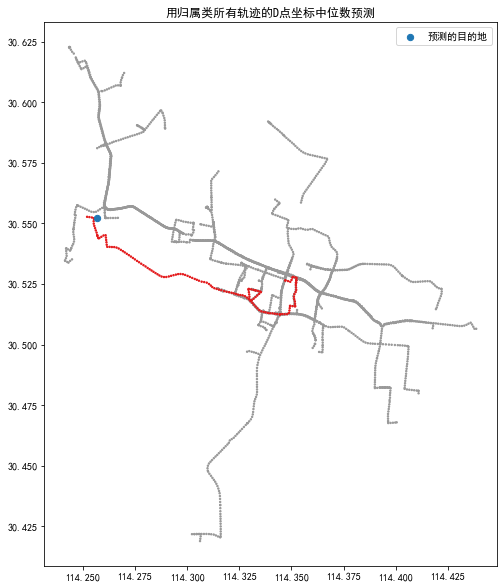

In [53]:
all_dests=gdf1.groupby(['cluster',"TID"]).last()[['经度','纬度']].median(level="cluster")
all_dests=all_dests.reset_index()
dst_lon=all_dests[all_dests['cluster']==c]['经度']
dst_lat=all_dests[all_dests['cluster']==c]['纬度']

gdf2 = gpd.GeoDataFrame(
    sub_df, geometry=gpd.points_from_xy(sub_df['经度'], sub_df['纬度']),crs=4326)
ax=gdf2.plot(column='test',markersize=2,figsize=(10,10),cmap='Set1')
dst=gpd.GeoDataFrame(geometry=gpd.points_from_xy([dst_lon],[dst_lat]), crs=4326)
dst.plot(ax=ax,markersize=40,label='预测的目的地')#预测的目的地
plt.title('用归属类所有轨迹的D点坐标中位数预测')
plt.legend()


参考材料：
https://github.com/bguillouet/trajectory_classification
https://github.com/bguillouet/destination_prediction